In [1]:
import numpy as np
import h5py
import tqdm
import copy
import torch
import pandas as pd
import sys
import random
import matplotlib.pyplot as plt
import csv
import argparse
import seaborn as sns
from collections import defaultdict

sys.path.append('../')
from utils.misc import args_parser, average_weights, average_tensors
from utils.misc import get_data, process_isolated 
from utils.misc import time_slide_df, restart_index
from utils.models import LSTM
from models import Informer, Autoformer, Transformer, DLinear, Linear, NLinear

from utils.fed_update import LocalUpdate, test_inference, test_inference_new
from sklearn import metrics
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [196]:
args = argparse.Namespace(
    close_size = 3,
    period_size = 3,
    out_dim = 1,
    test_days = 7,
    val_days = 0,
    seed = 1,
    bs = 100,
    frac = 0.1,
    fedsgd = 1,
    local_bs = 20,
    epochs = 100,
    file = "milano.h5",
    type = "sms",
    gpu = "True",
    lr = 0.01,
    opt = 'sgd',
    momentum = 0.9,
    local_epoch = 1
)
device = 'cuda' if args.gpu else 'cpu'



In [197]:
normalized_df, selected_cells_df, selected_cells, mean, std, cell_lng, cell_lat, ori_df = get_data(args)
mean = ori_df.mean()
std = ori_df.std()

In [34]:
normalized_ori_df = (ori_df - mean) / std
normalized_ori_df = normalized_ori_df.reset_index()
normalized_ori_df = normalized_ori_df.rename(columns={'index': 'date_time'})

In [5]:
sel_cell= [7575,7479,7080,8070,7073,8073,7474]

ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of ticklabels (121).

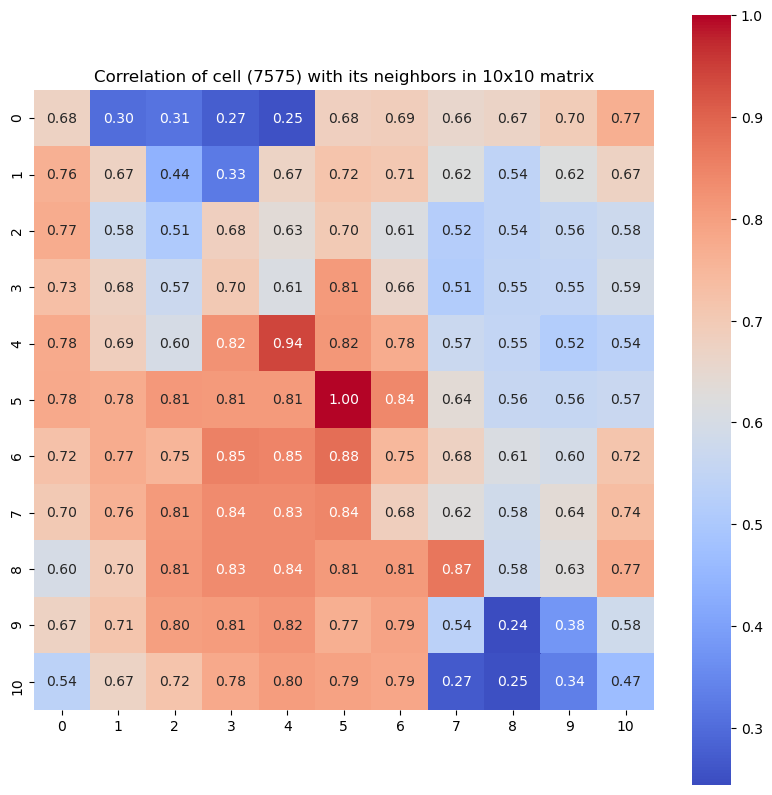

In [115]:
# 대상 셀의 ID 지정
target_cell_id = 7575  # 예시 값

# 한 행에 몇 개의 셀이 있는지
cells_per_row = 100

# target_cell의 좌표 (i,j) 계산
i, j = divmod(target_cell_id - 1, cells_per_row)
i += 1
j += 1

# 주변 셀들의 위치 계산 (11x11 행렬)
neighbors = [(i + di, j + dj) for di in range(-5, 6) for dj in range(-5, 6)]
neighbors_ids = [(x - 1) * cells_per_row + y for x, y in neighbors]
neighbors_labels = [str(cell_id) for cell_id in neighbors_ids if cell_id in normalized_ori_df.columns]


# ori_df에 존재하는 컬럼만 골라냄
valid_ids = [cell_id for cell_id in neighbors_ids if cell_id in normalized_ori_df.columns]

# 대상 셀과 주변 셀들과의 상관관계 계산
correlations = normalized_ori_df.corr().loc[target_cell_id, valid_ids]

# 10x10 매트릭스 생성
correlation_matrix = np.full((11, 11), np.nan)

# target cell의 위치에 따른 주변 셀의 상관관계 설정
for cell_id in valid_ids:
    x, y = divmod(cell_id - 1, cells_per_row)
    x += 1
    y += 1
    dx = x - i
    dy = y - j
    if -5 <= dx <= 5 and -5 <= dy <= 5:  # 새로운 조건 추가
        if (dx, dy) == (0, 0):
            correlation_matrix[5, 5] = 1.0  # target cell 자신과의 상관관계는 1입니다.
        else:
            correlation_matrix[dx + 5, dy + 5] = correlations.get(cell_id, np.nan)



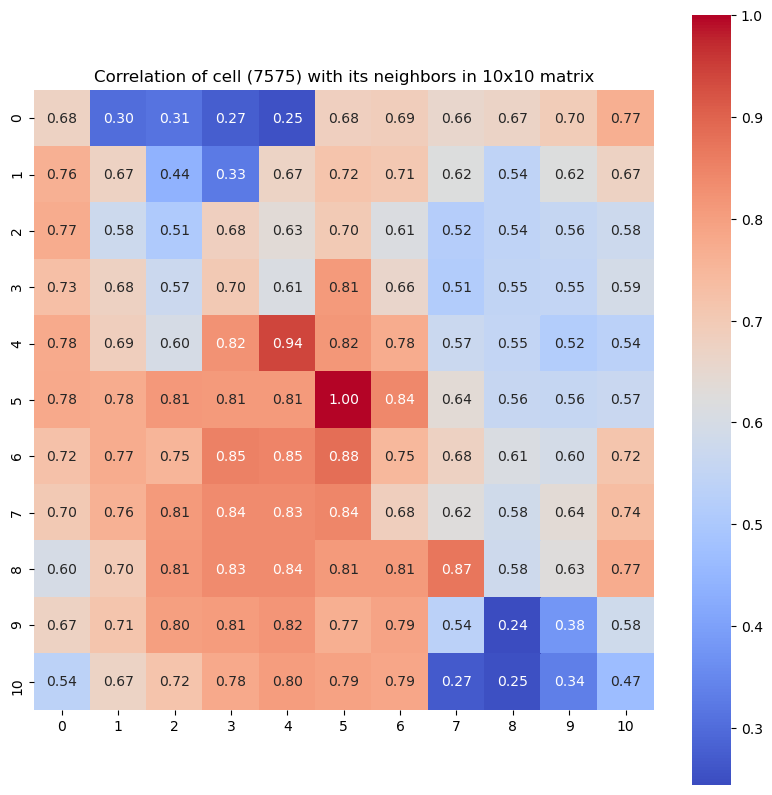

<Figure size 640x480 with 0 Axes>

In [116]:
# 히트맵 그리기
plt.figure(figsize=(10, 10))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.title(f'Correlation of cell ({target_cell_id}) with its neighbors in 10x10 matrix')


plt.show()

# correlation_matrix를 NumPy 배열로 저장
np.save('correlation_matrix.npy', correlation_matrix)

# 히트맵을 이미지로 저장
plt.savefig(f'cell:{target_cell_id}_normalized_corrleation_heatmap.png')

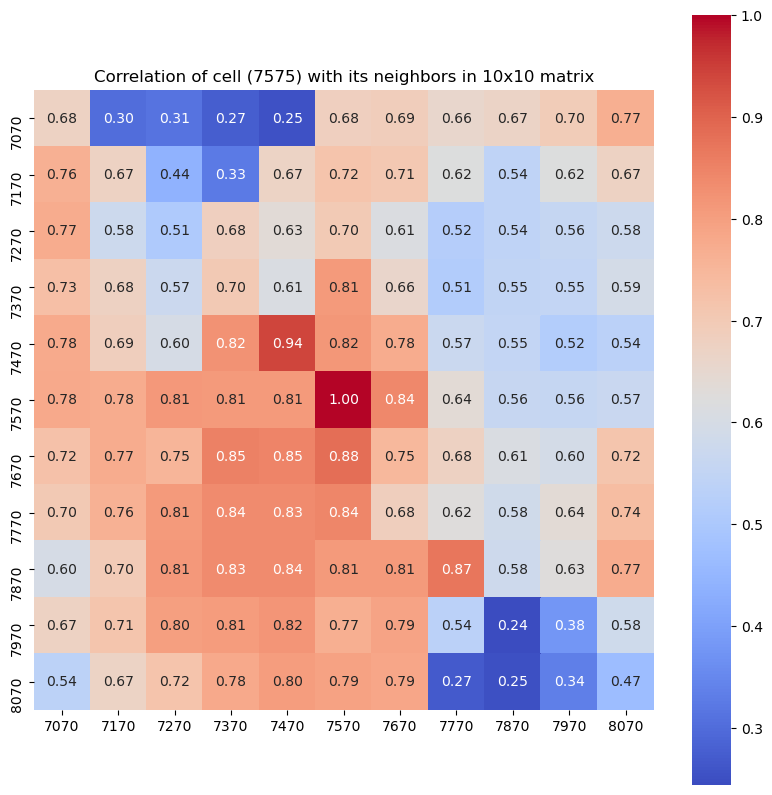

In [69]:
# 대상 셀과 주변 셀들의 상관 관계 계산 등

# 히트맵 그리기
plt.figure(figsize=(10, 10))

# 이웃 셀들의 실제 cell ID 값을 tick 레이블로 사용
xticklabels = [str(cell_id) for i, cell_id in enumerate(neighbors_ids) if i % 11 == 0]
yticklabels = [str(cell_id) for i, cell_id in enumerate(neighbors_ids) if i % 11 == 0]

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True,
            fmt='.2f', annot_kws={'size': 10},
            xticklabels=xticklabels, yticklabels=yticklabels)

plt.title(f'Correlation of cell ({target_cell_id}) with its neighbors in 10x10 matrix')

# 히트맵과 상관계수 행렬 저장
plt.savefig(f'cell:{target_cell_id}_original_corrleation_heatmap.png')
np.save(f'cell:{target_cell_id}_original_correlation_matrix.npy', correlation_matrix)

plt.show()

In [198]:
# Decomposition Visualization

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# 빈 데이터프레임 생성
decomposed_trend = pd.DataFrame(index=normalized_df.index)
decomposed_seasonal = pd.DataFrame(index=normalized_df.index)

# 각 열(column)에 대한 분해(decomposition) 수행
for column in normalized_df.columns:
    series = normalized_df[column]
    
    # 결측값이 있으면 처리
    series.dropna(inplace=True)

    # series가 너무 짧으면 분해할 수 없으므로 건너뜀
    if len(series) < 2:
        continue

    try:
        result = seasonal_decompose(series, model='additive', period=24)  # 주기는 데이터에 따라 조정해야 함
        decomposed_trend[column] = result.trend
        decomposed_seasonal[column] = result.seasonal
    except Exception as e:
        print(f"An exception occurred for column {column}: {e}")

print(decomposed_trend)
print(decomposed_seasonal)


                     35     157    214    370    383    436    484    495    \
2013-11-04 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-11-04 01:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-11-04 02:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-11-04 03:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-11-04 04:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2013-12-29 19:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-12-29 20:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-12-29 21:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-12-29 22:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2013-12-29 23:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                     504    521    ...  9106   9164

In [54]:
# LinearRegression 을 통한 trend_labels
from sklearn.linear_model import LinearRegression

# 빈 Series 생성
trend_labels = pd.Series(index=decomposed_trend.columns, dtype='object')

# 각 열(column)에 대한 라벨링 수행
for column in decomposed_trend.columns:
    y = decomposed_trend[column].dropna()  # NaN 제거
    X = np.array(range(len(y))).reshape(-1, 1)
    
    if len(y) > 1:  # 데이터가 충분해야 회귀를 실행할 수 있습니다. 
        try:
            model = LinearRegression()
            model.fit(X, y)
            slope = model.coef_[0]  # coef_ returns a 1D array
            trend_labels[column] = 'UP' if slope > 0 else 'DOWN'
        except Exception as e:
            print(f"Error for column {column}: {e}")
            trend_labels[column] = f'ERROR: {str(e)}'
    else:
        trend_labels[column] = 'NOT ENOUGH DATA'

print(trend_labels)

date_time      UP
38             UP
39             UP
40           DOWN
154            UP
             ... 
11336          UP
11337          UP
11452          UP
11453          UP
11454          UP
Length: 6260, dtype: object


In [199]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

n_trend_clusters = 5
n_seasonal_clusters = 2

decomposed_trend.dropna(inplace=True)
decomposed_seasonal.dropna(inplace=True)

# Trend clustering using K-means
kmeans_trend = KMeans(n_clusters=n_trend_clusters, random_state=0).fit(decomposed_trend.T)  # Transpose to get samples

# Retrieve labels
trend_labels = kmeans_trend.labels_
trend_df_labels = pd.DataFrame({'Cell': decomposed_trend.columns, 'Cluster': trend_labels})

# Seasonal clustering using K-means
kmeans_seasonal = KMeans(n_clusters=n_seasonal_clusters, random_state=0).fit(decomposed_seasonal.T)  # Transpose to get samples and use decomposed_seasonal

# Retrieve labels
seasonal_labels = kmeans_seasonal.labels_
seasonal_df_labels = pd.DataFrame({'Cell': decomposed_seasonal.columns, 'Cluster': seasonal_labels})  # Use decomposed_seasonal columns


In [200]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def find_optimal_clusters(data, max_clusters):
    silhouette_vals = []
    
    for cluster in range(2, max_clusters):  # Start from 2 because silhouette score requires at least 2 clusters
        kmeans = KMeans(n_jobs=-1, n_clusters=cluster, random_state=0).fit(data)
        silhouette_vals.append(silhouette_score(data, kmeans.labels_))
    
    optimal_cluster_num = silhouette_vals.index(max(silhouette_vals)) + 2  # +2 because the range starts from 2
    return optimal_cluster_num

max_clusters = 10
optimal_trend_clusters = find_optimal_clusters(decomposed_trend.T, max_clusters)
optimal_seasonal_clusters = find_optimal_clusters(decomposed_seasonal.T, max_clusters)

kmeans_trend = KMeans(n_clusters=optimal_trend_clusters, random_state=0).fit(decomposed_trend.T)
trend_df_labels = pd.DataFrame({'Cell': decomposed_trend.columns, 'Cluster': kmeans_trend.labels_})

kmeans_seasonal = KMeans(n_clusters=optimal_seasonal_clusters, random_state=0).fit(decomposed_seasonal.T)
seasonal_df_labels = pd.DataFrame({'Cell': decomposed_seasonal.columns, 'Cluster': kmeans_seasonal.labels_})

kmeans_trend = KMeans(n_clusters=4, random_state=0).fit(decomposed_trend.T)
trend_df_labels = pd.DataFrame({'Cell': decomposed_trend.columns, 'Cluster': kmeans_trend.labels_})


/usr/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/usr/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/usr/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/usr/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/usr/anacond

In [219]:
from sklearn.cluster import DBSCAN

#DBSCAN Clustering
dbscan = DBSCAN(eps=0.01, min_samples=1)
clusters = dbscan.fit_predict(decomposed_trend.T)





In [220]:
clusters

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

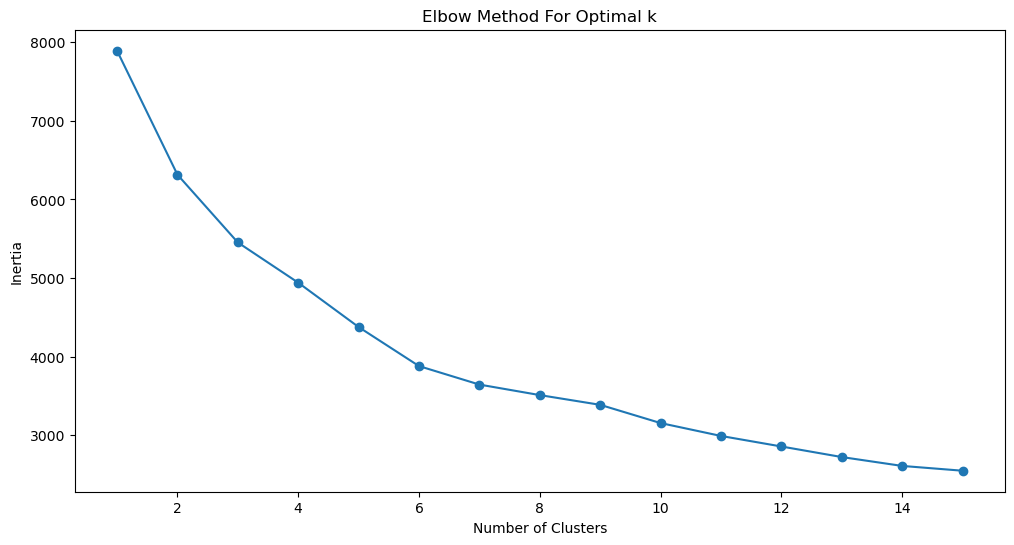

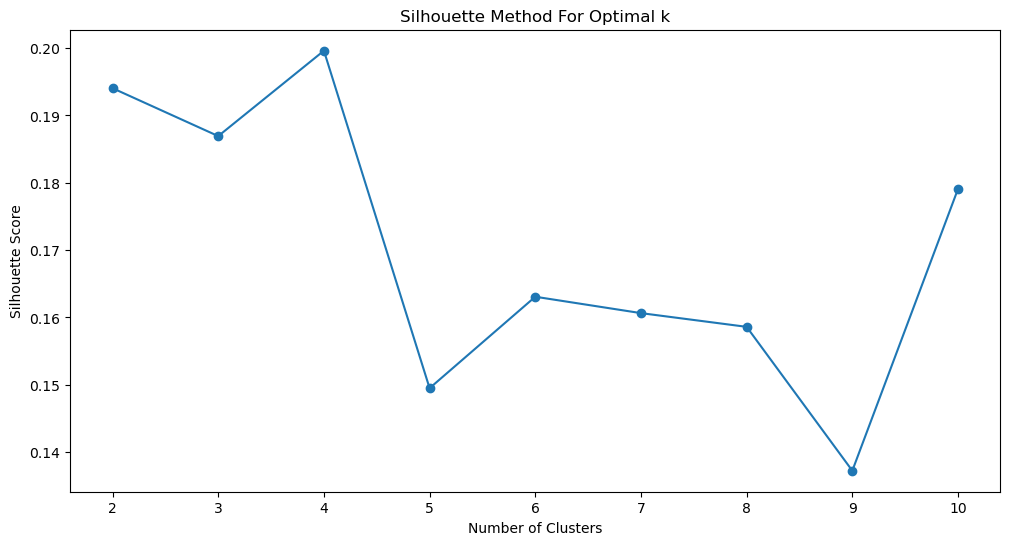

In [202]:
from sklearn.metrics import silhouette_score


inertia = []
K_range = range(1, 16)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(decomposed_trend.T)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


silhouette = []
K_range = range(2, 11)  # Silhouette Analysis는 최소 2개 클러스터가 필요합니다.

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(decomposed_trend.T)
    silhouette.append(silhouette_score(decomposed_trend.T, kmeans.labels_))

plt.figure(figsize=(12, 6))
plt.plot(K_range, silhouette, marker='o')
plt.title('Silhouette Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

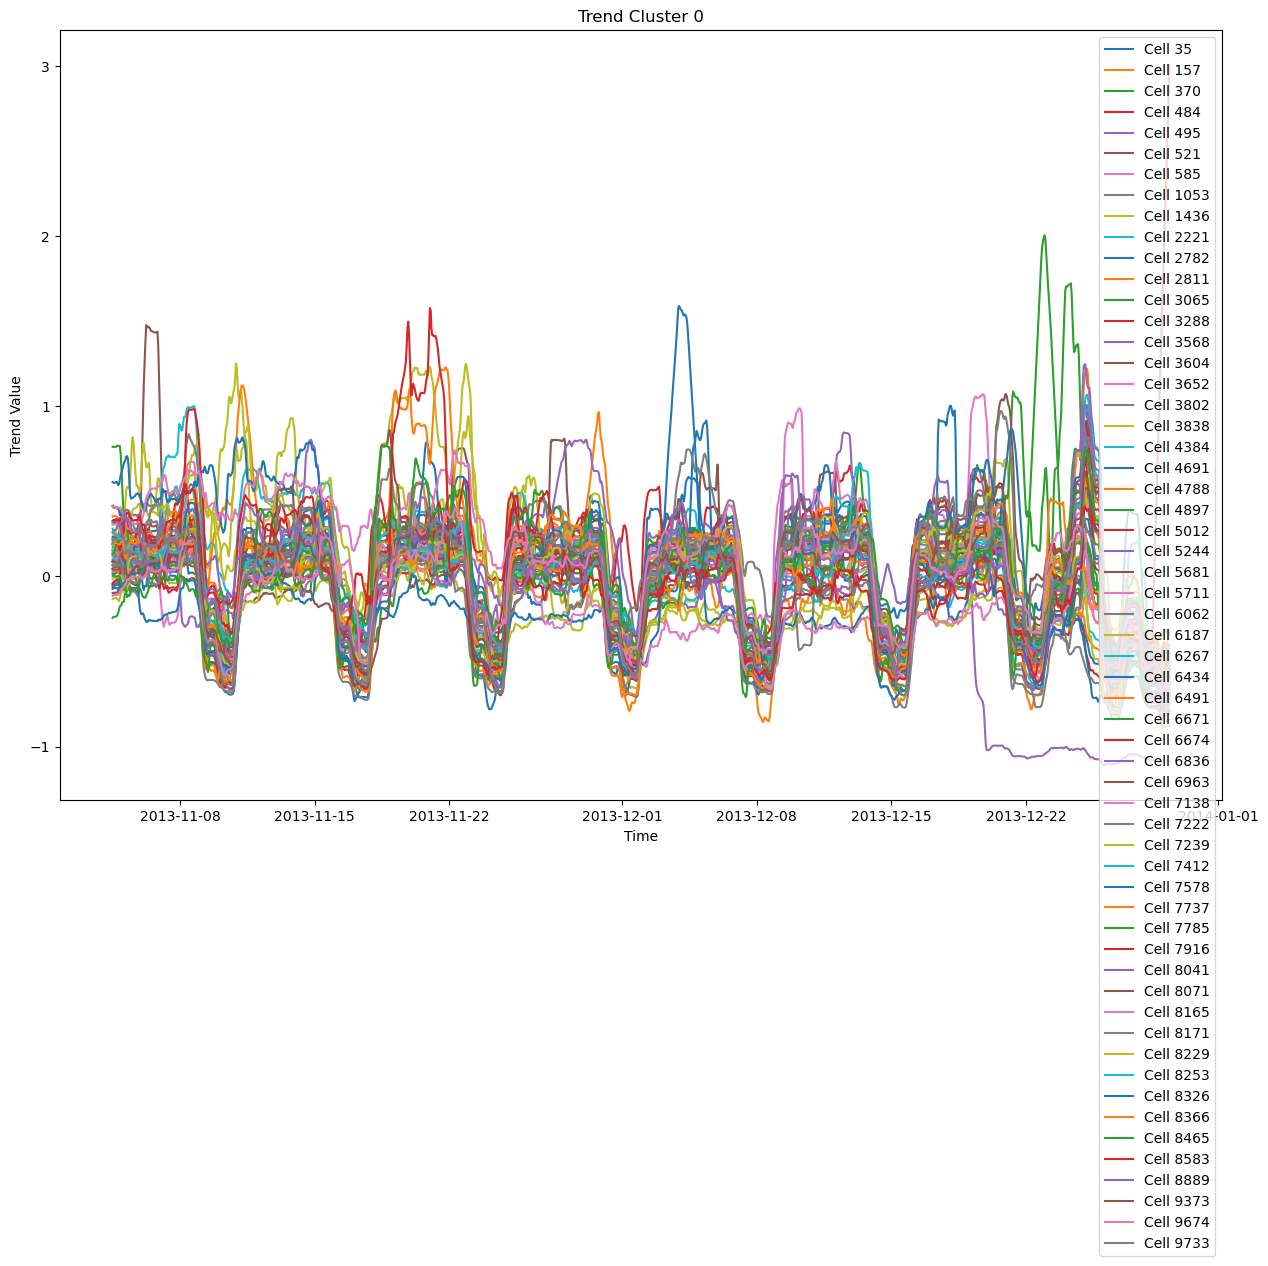

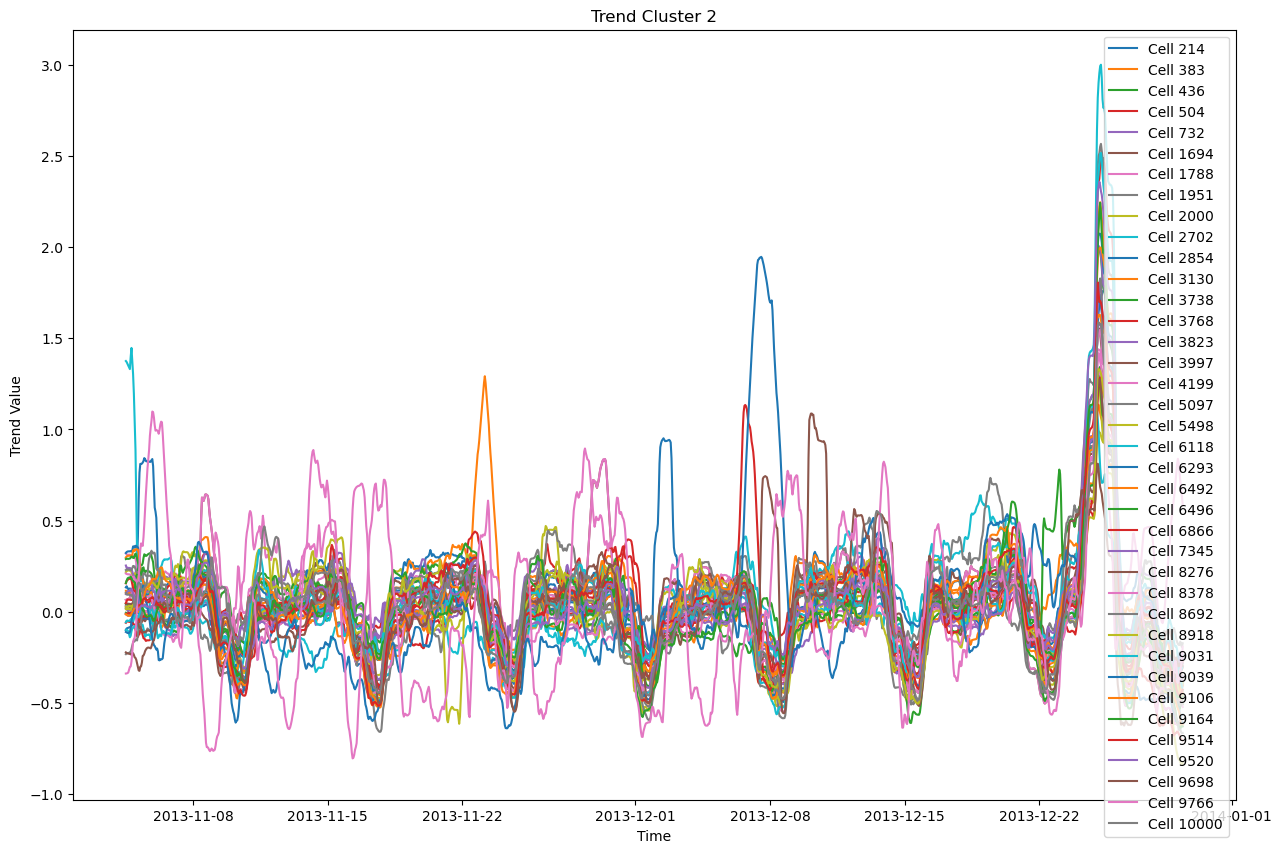

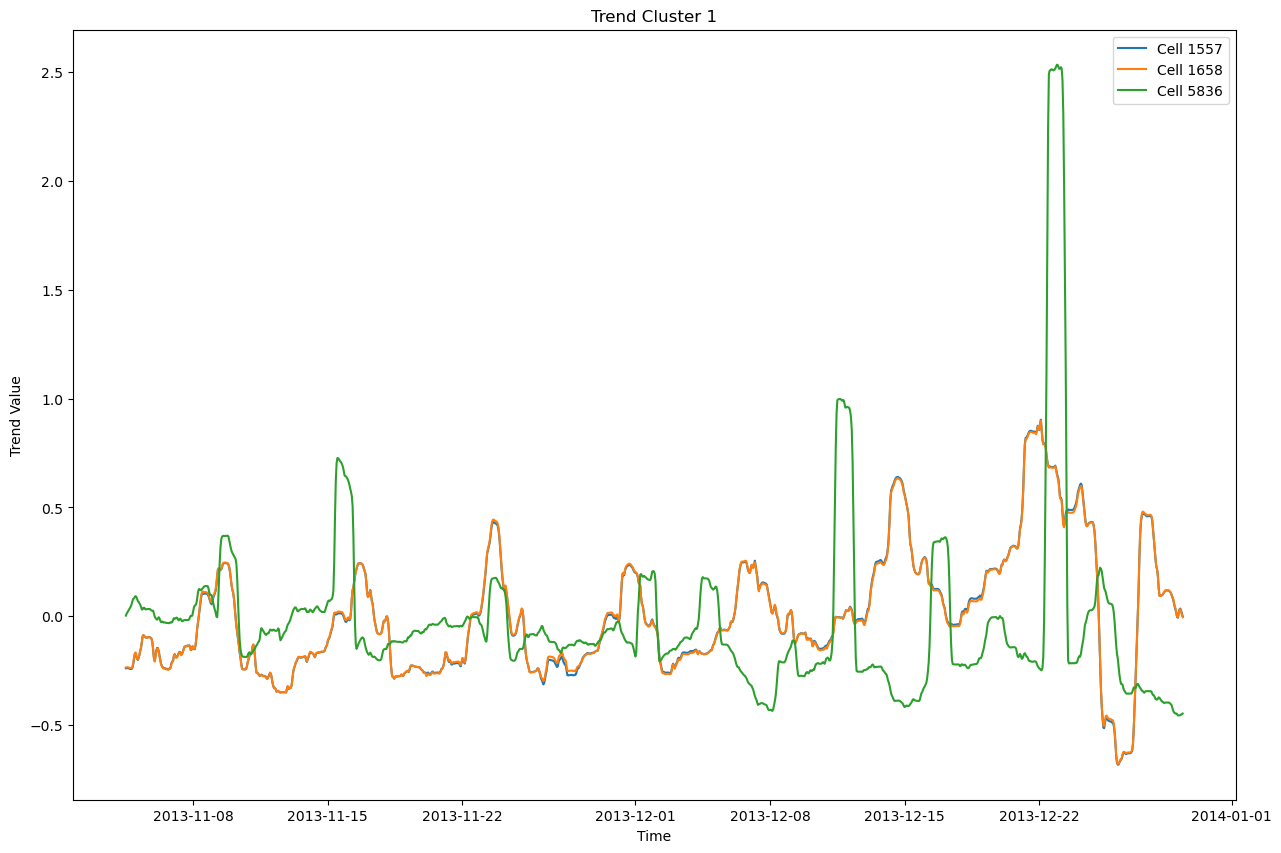

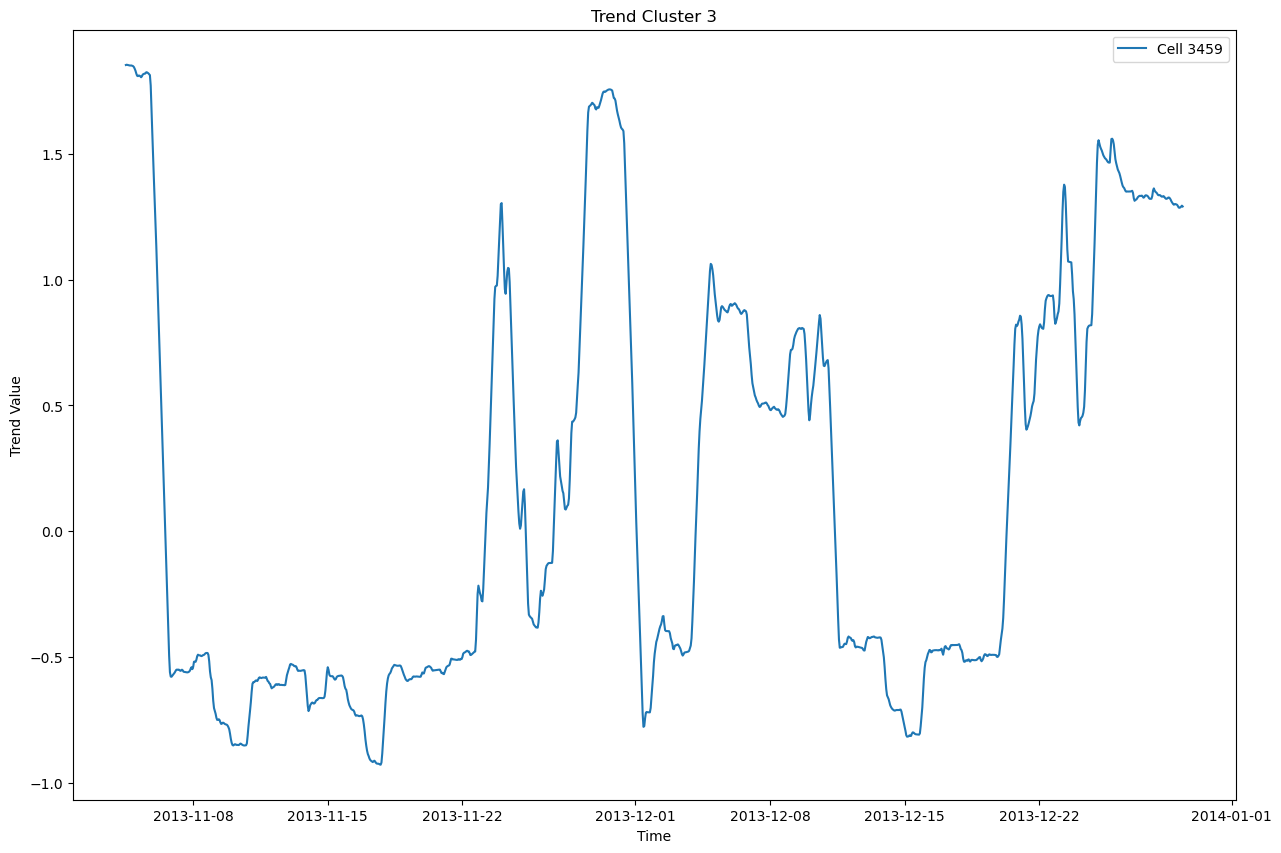

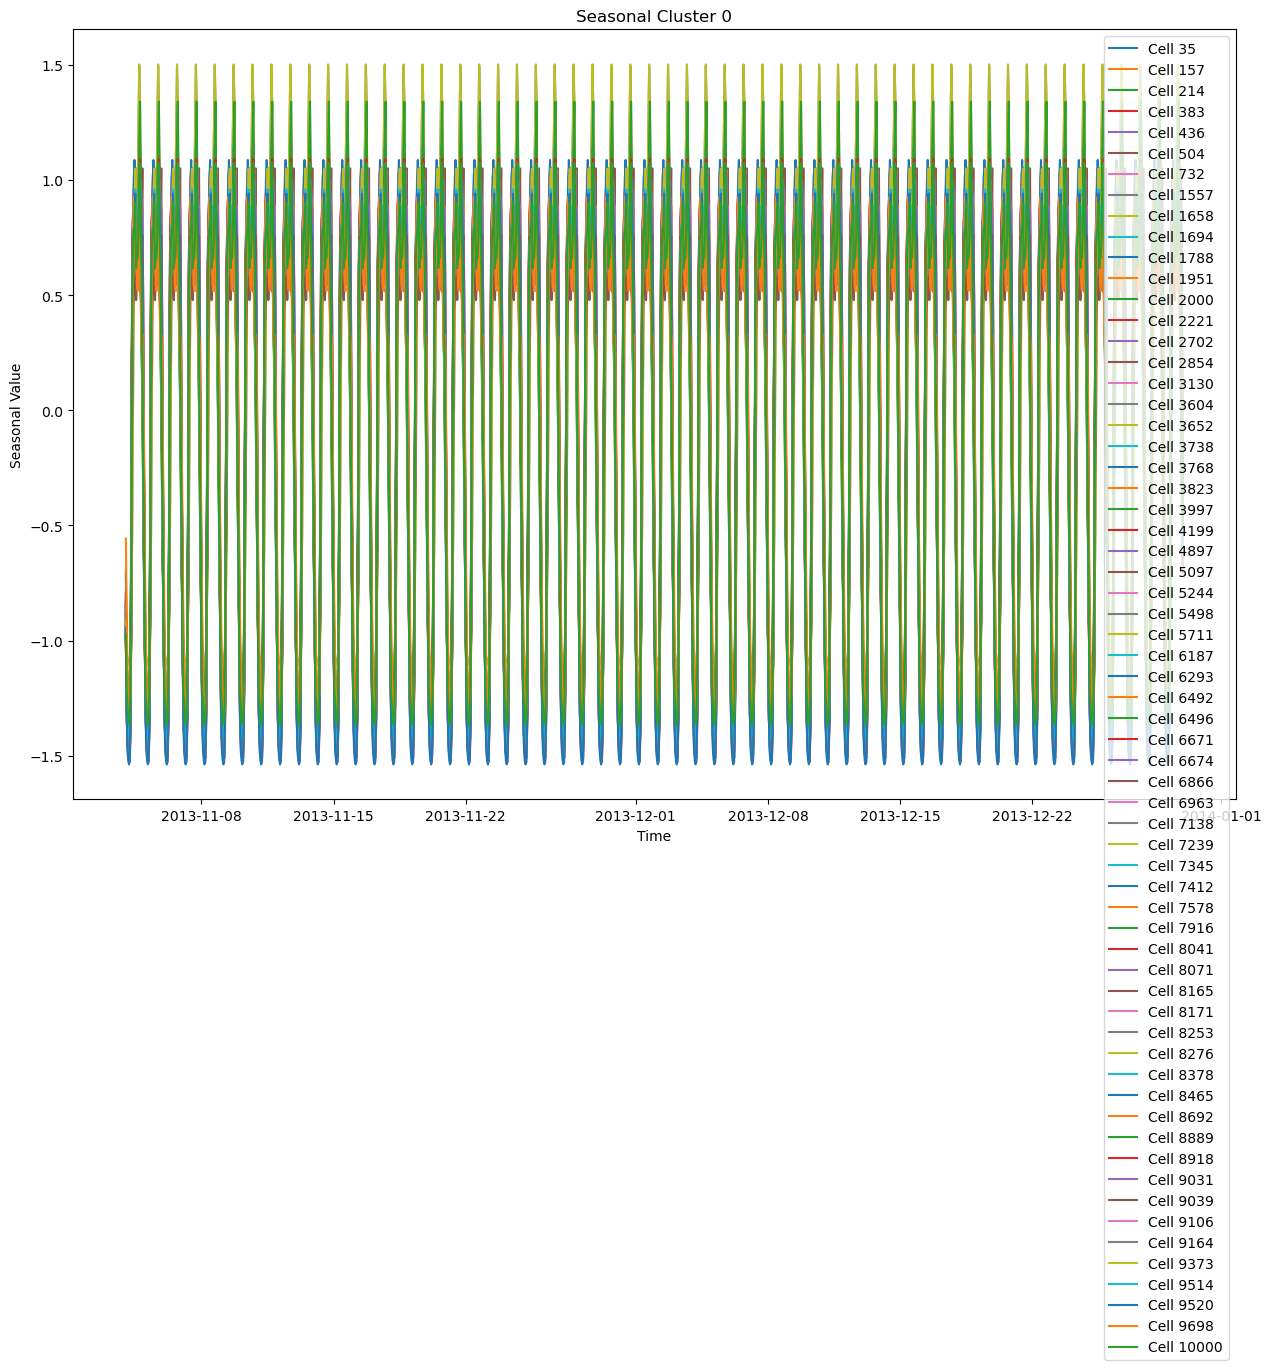

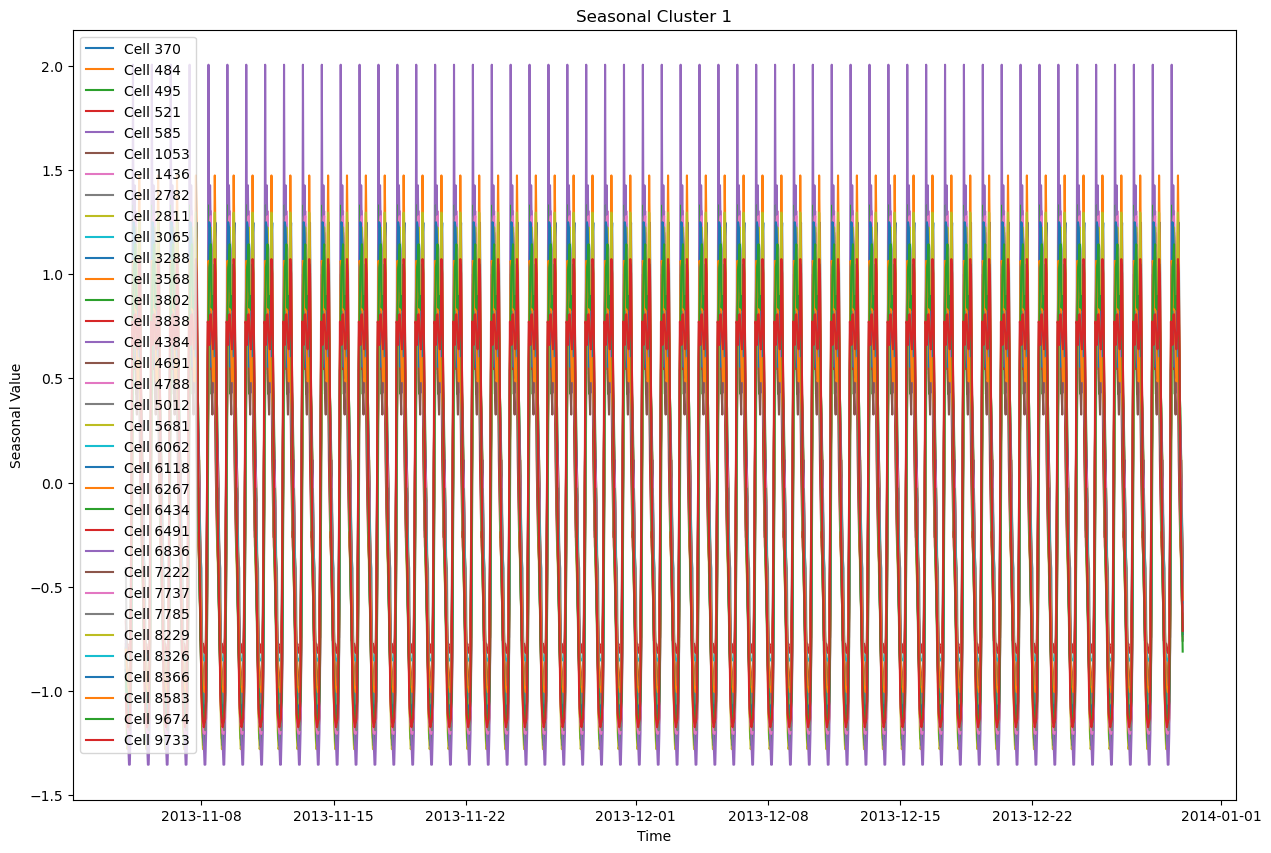

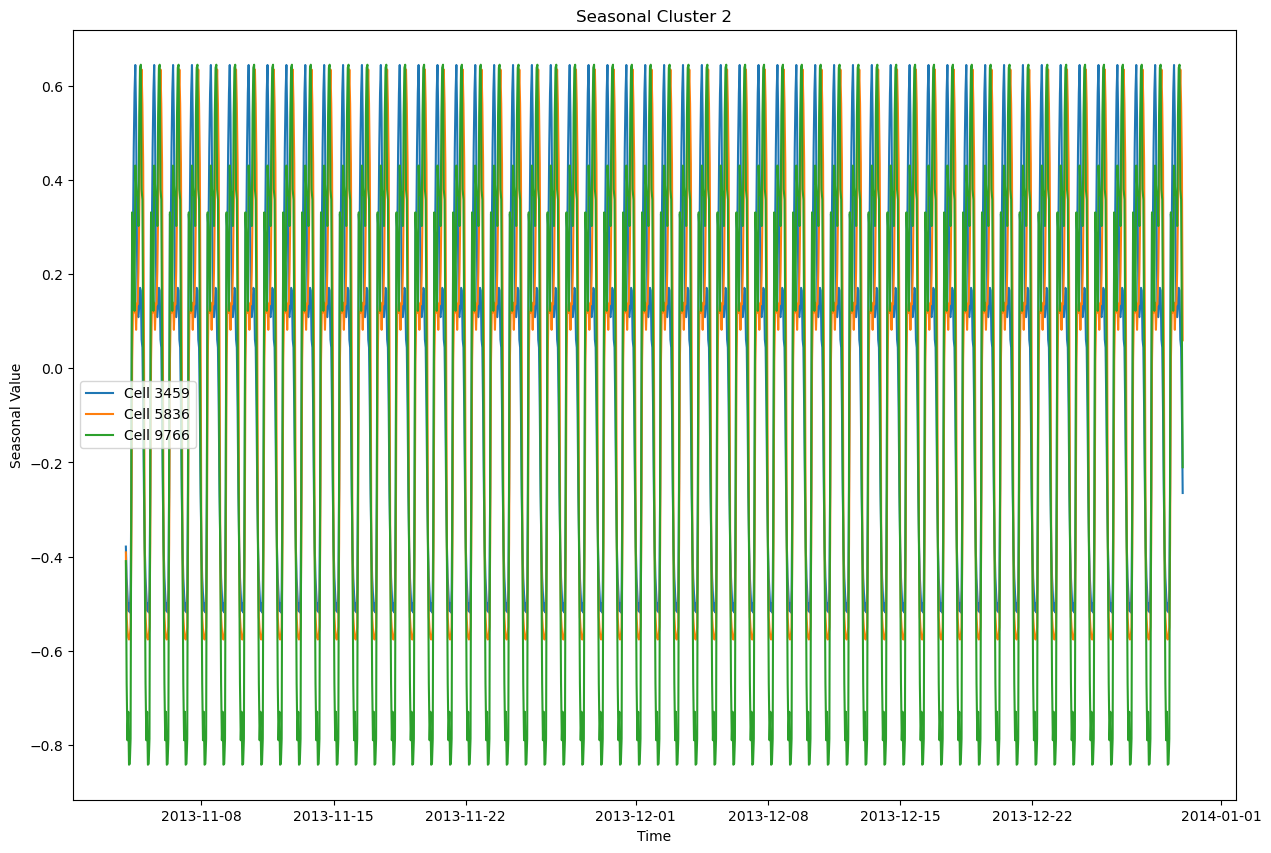

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clustered_data(cluster_df, decomposed_data, title_prefix):
    # 유니크한 클러스터 라벨을 얻습니다.
    unique_clusters = cluster_df['Cluster'].unique()

    # 유니크한 클러스터 라벨 각각에 대해 그래프를 그립니다.
    for cluster in unique_clusters:
        plt.figure(figsize=(15, 10))

        # 특정 클러스터에 속한 모든 셀들의 이름을 가져옵니다.
        selected_cells = cluster_df[cluster_df['Cluster'] == cluster]['Cell']

        # 가져온 셀 이름에 해당하는 열만 선택해서 그립니다.
        subset = decomposed_data[selected_cells]
        
        for cell in selected_cells:
            plt.plot(subset[cell], label=f'Cell {cell}')
            
        plt.legend()
        plt.title(f'{title_prefix} Cluster {cluster}')
        plt.xlabel('Time')
        plt.ylabel(f'{title_prefix} Value')
        plt.show()

# trend와 seasonal 데이터에 대해 클러스터링 결과를 시각화합니다.
plot_clustered_data(trend_df_labels, decomposed_trend, "Trend")
plot_clustered_data(seasonal_df_labels, decomposed_seasonal, "Seasonal")


In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

# 유니크한 클러스터 라벨을 얻습니다.
unique_clusters = trend_labels['Cluster'].unique()

# 유니크한 클러스터 라벨 각각에 대해 그래프를 그립니다.
for cluster in unique_clusters:
    plt.figure(figsize=(15, 10))

    # 특정 클러스터에 속한 모든 셀들의 이름을 가져옵니다.
    selected_cells = trend_labels[trend_labels['Cluster'] == cluster]['Cell']

    # 가져온 셀 이름에 해당하는 열만 선택해서 그립니다.
    subset = decomposed_trend[selected_cells]
    
    for cell in selected_cells:
        plt.plot(subset[cell], label=f'Cell {cell}')
        
    plt.legend()
    plt.title(f'Cluster {cluster}')
    plt.xlabel('Time')
    plt.ylabel('Trend Value')
    plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 1500x1000 with 0 Axes>

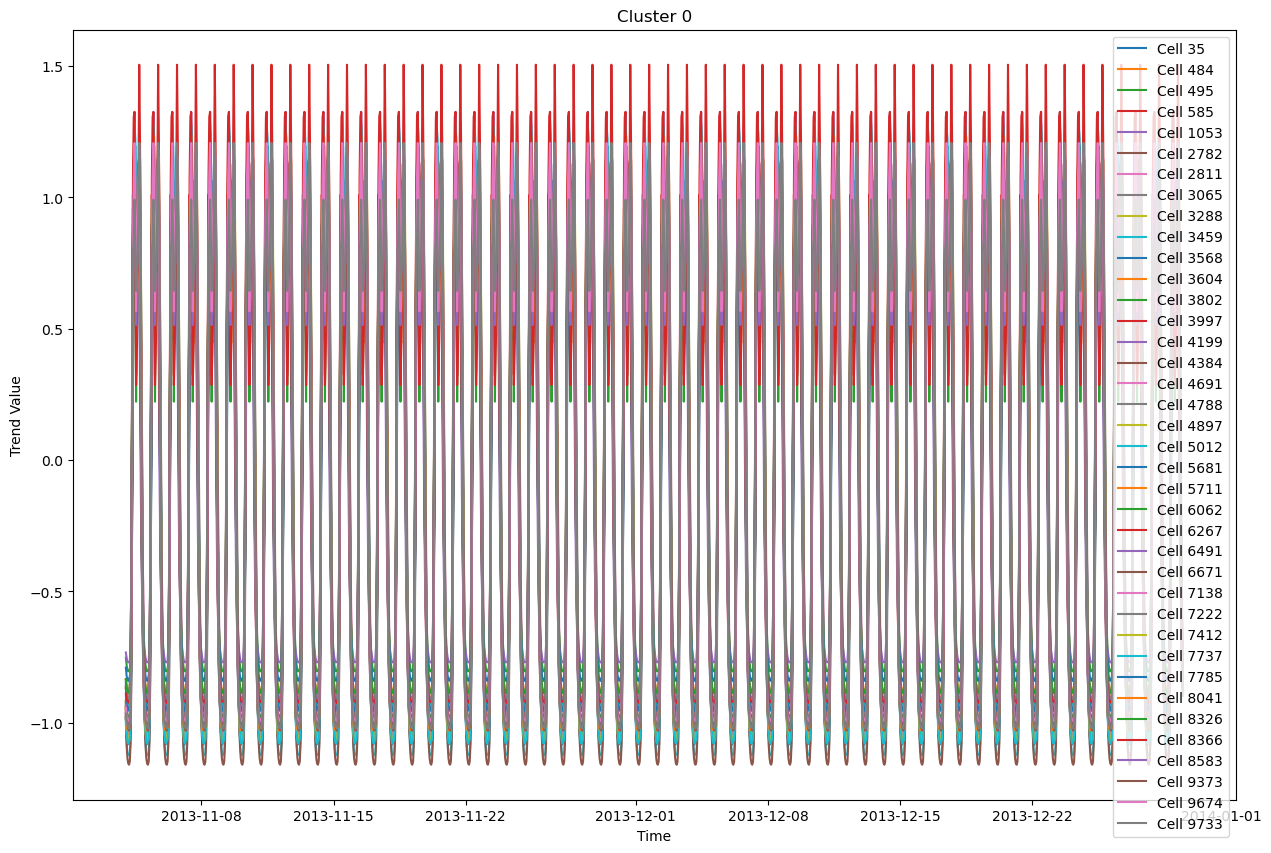

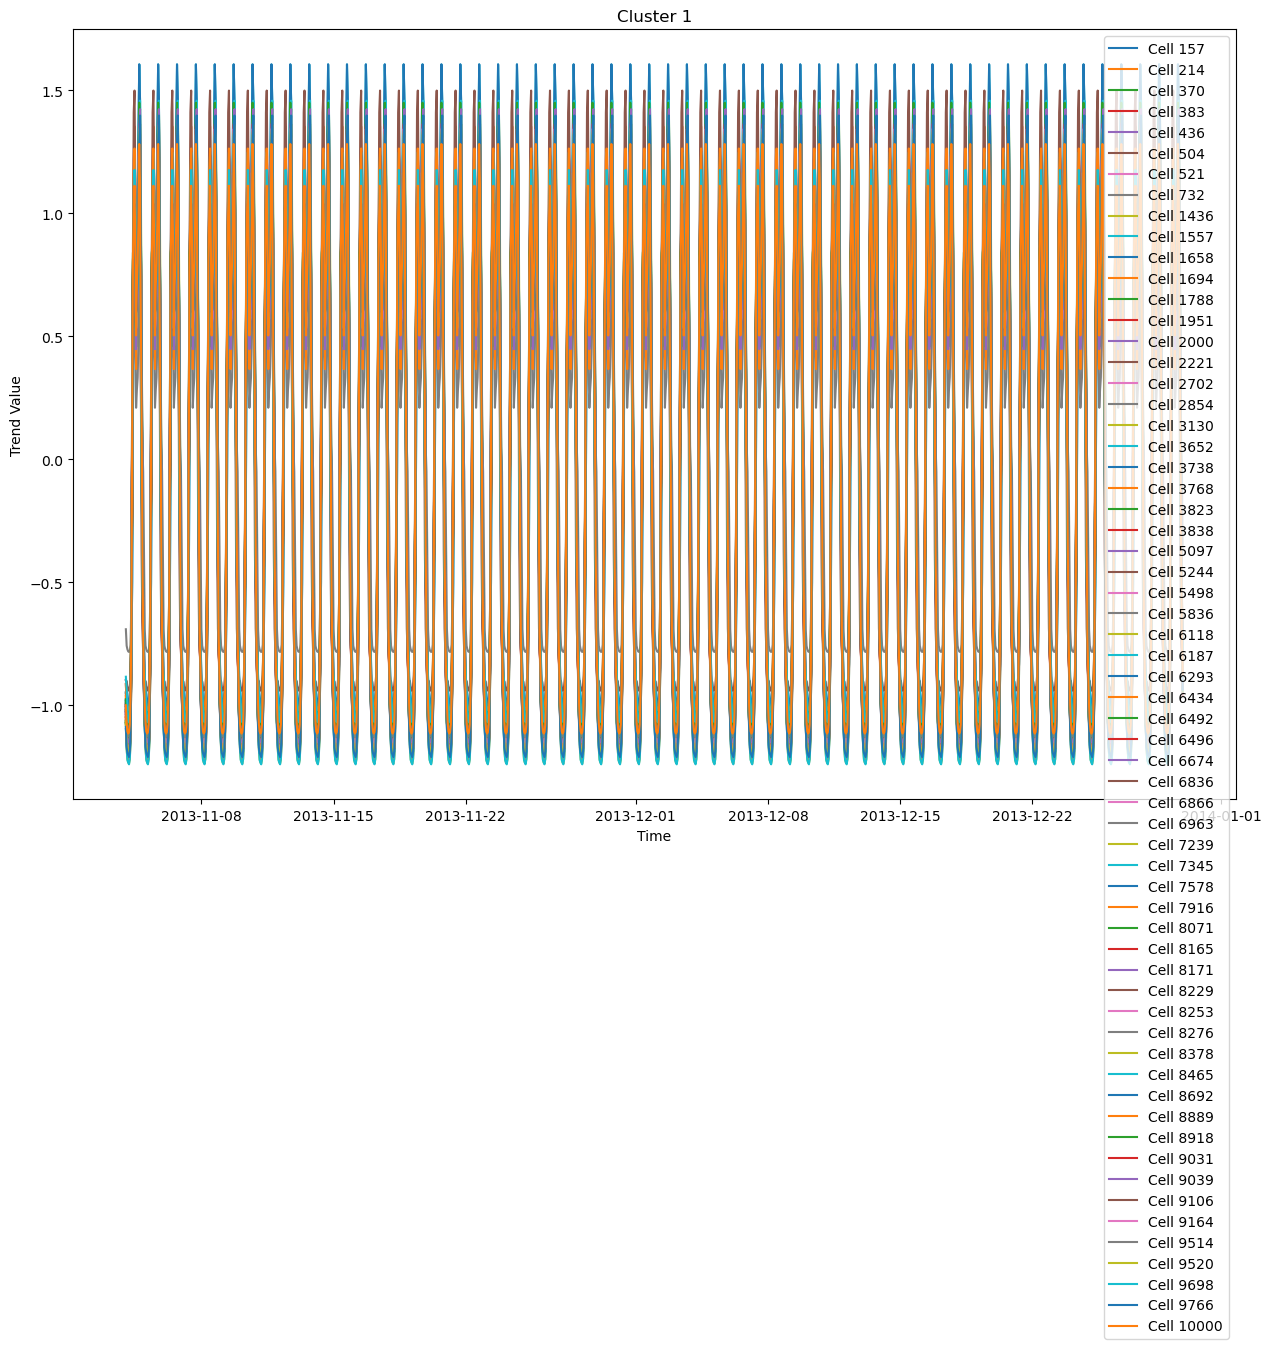

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

# 유니크한 클러스터 라벨을 얻습니다.
unique_clusters = seasonal_labels['Cluster'].unique()

# 유니크한 클러스터 라벨 각각에 대해 그래프를 그립니다.
for cluster in unique_clusters:
    plt.figure(figsize=(15, 10))

    # 특정 클러스터에 속한 모든 셀들의 이름을 가져옵니다.
    selected_cells = seasonal_labels[seasonal_labels['Cluster'] == cluster]['Cell']

    # 가져온 셀 이름에 해당하는 열만 선택해서 그립니다.
    subset = decomposed_seasonal[selected_cells]
    
    for cell in selected_cells:
        plt.plot(subset[cell], label=f'Cell {cell}')
        
    plt.legend()
    plt.title(f'Cluster {cluster}')
    plt.xlabel('Time')
    plt.ylabel('Trend Value')
    plt.show()

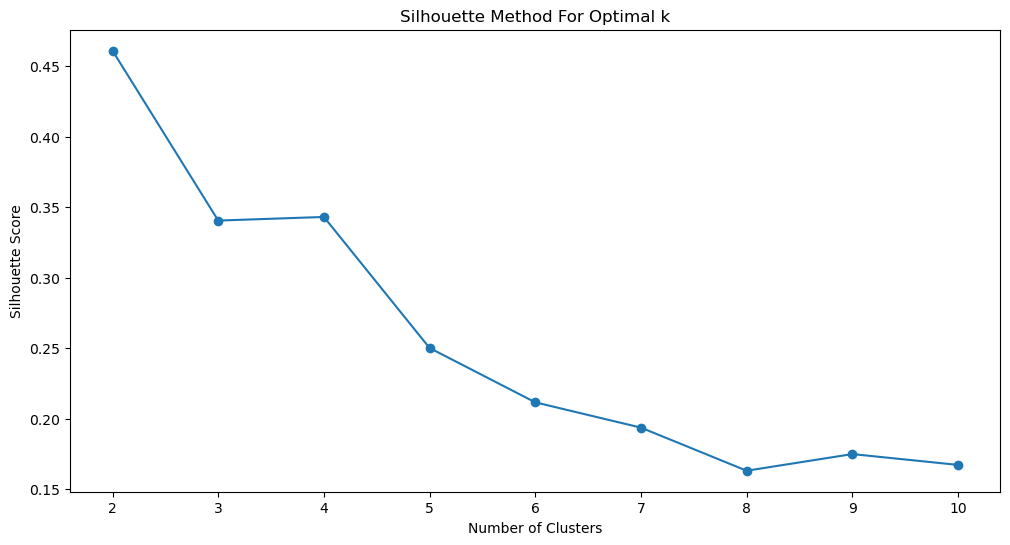

In [101]:
from sklearn.metrics import silhouette_score

silhouette = []
K_range = range(2, 11)  # Silhouette Analysis는 최소 2개 클러스터가 필요합니다.

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(decomposed_trend.T)
    silhouette.append(silhouette_score(decomposed_trend.T, kmeans.labels_))

plt.figure(figsize=(12, 6))
plt.plot(K_range, silhouette, marker='o')
plt.title('Silhouette Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

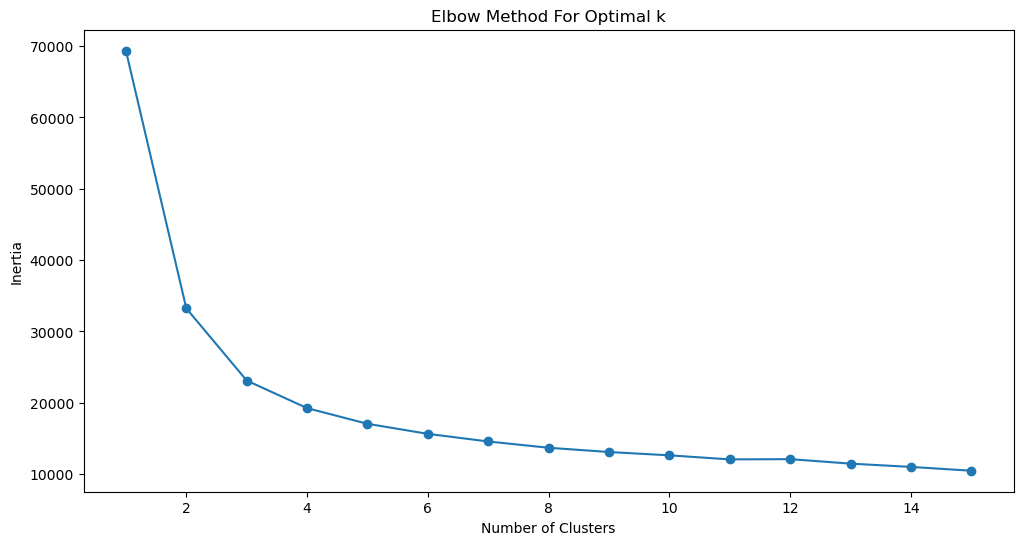

In [102]:
inertia = []
K_range = range(1, 16)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(decomposed_trend.T)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

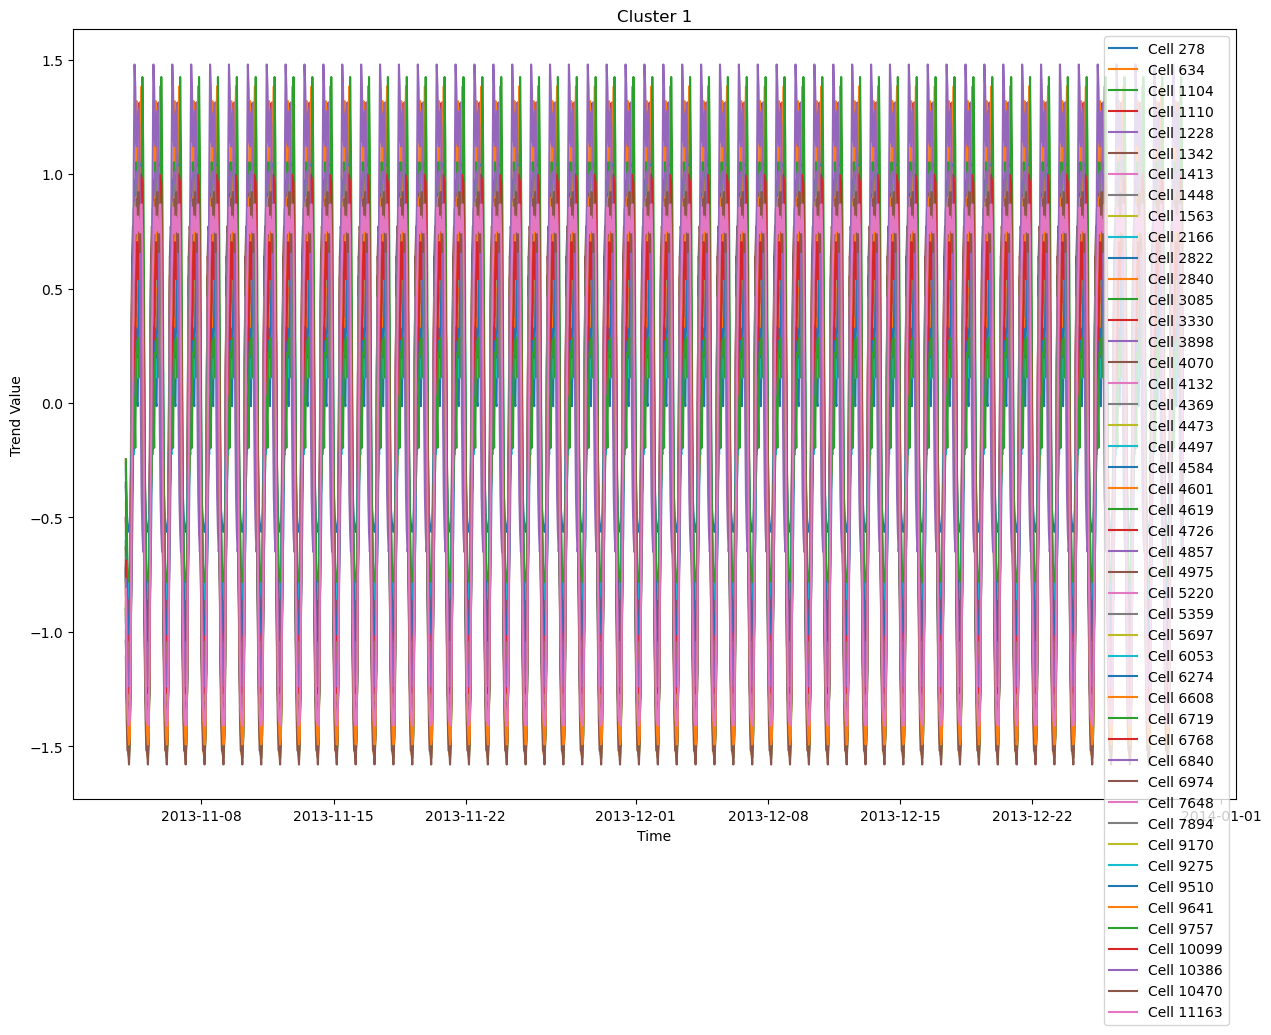

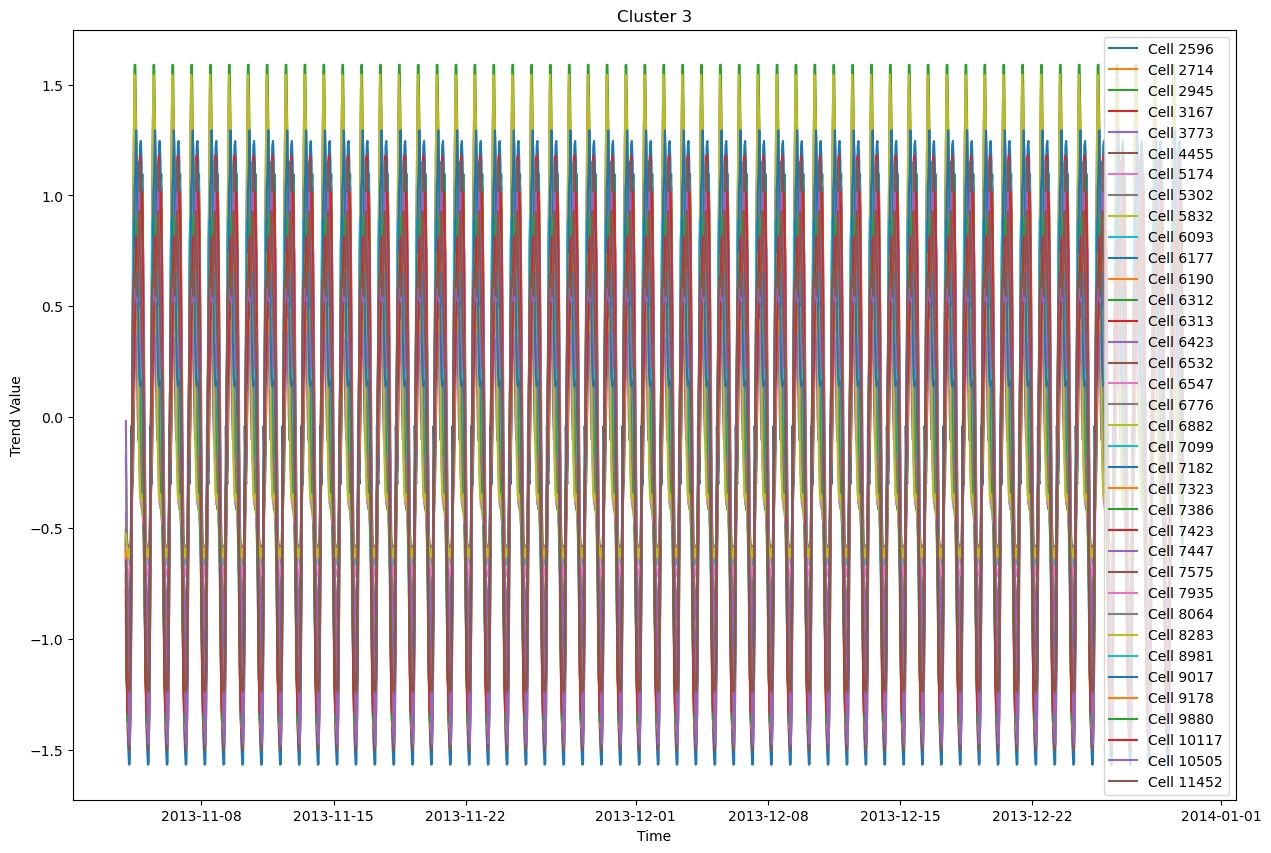

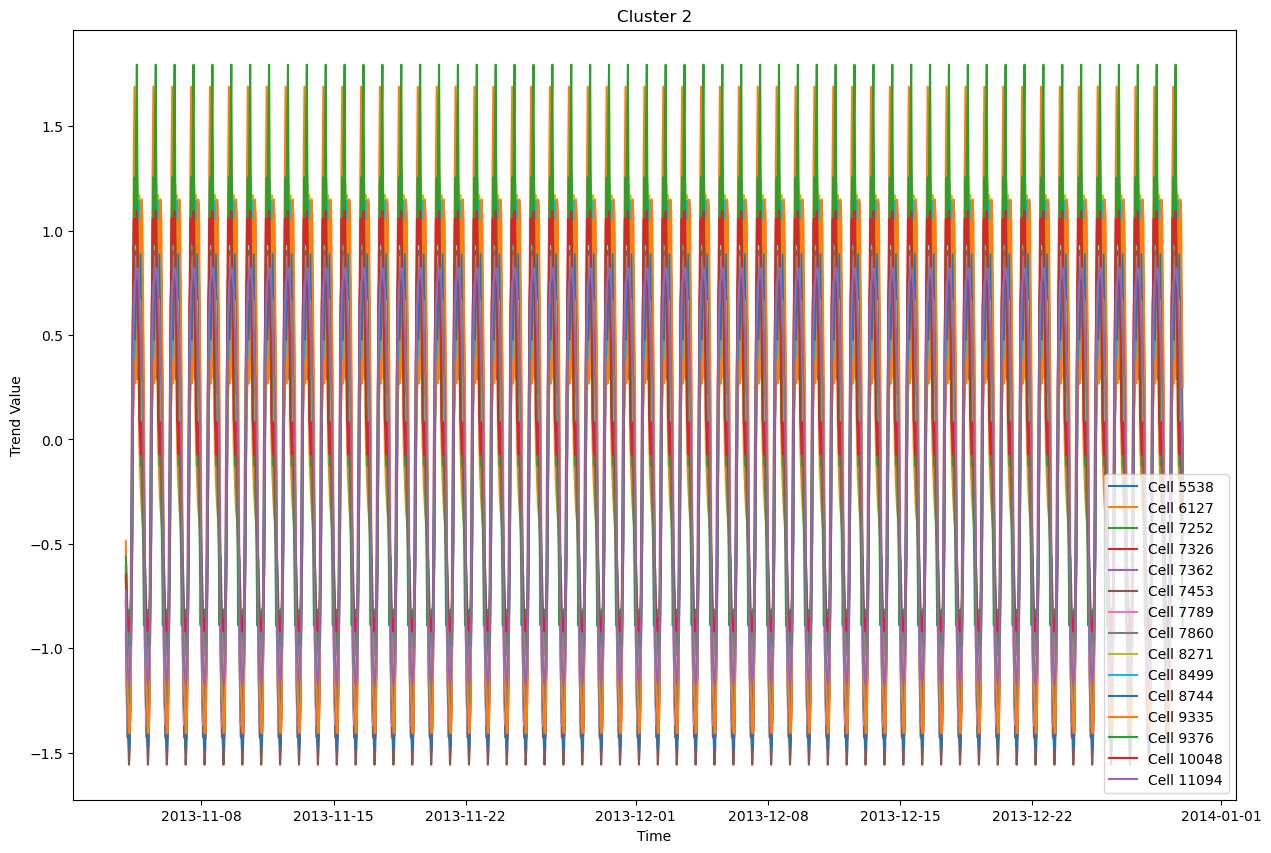

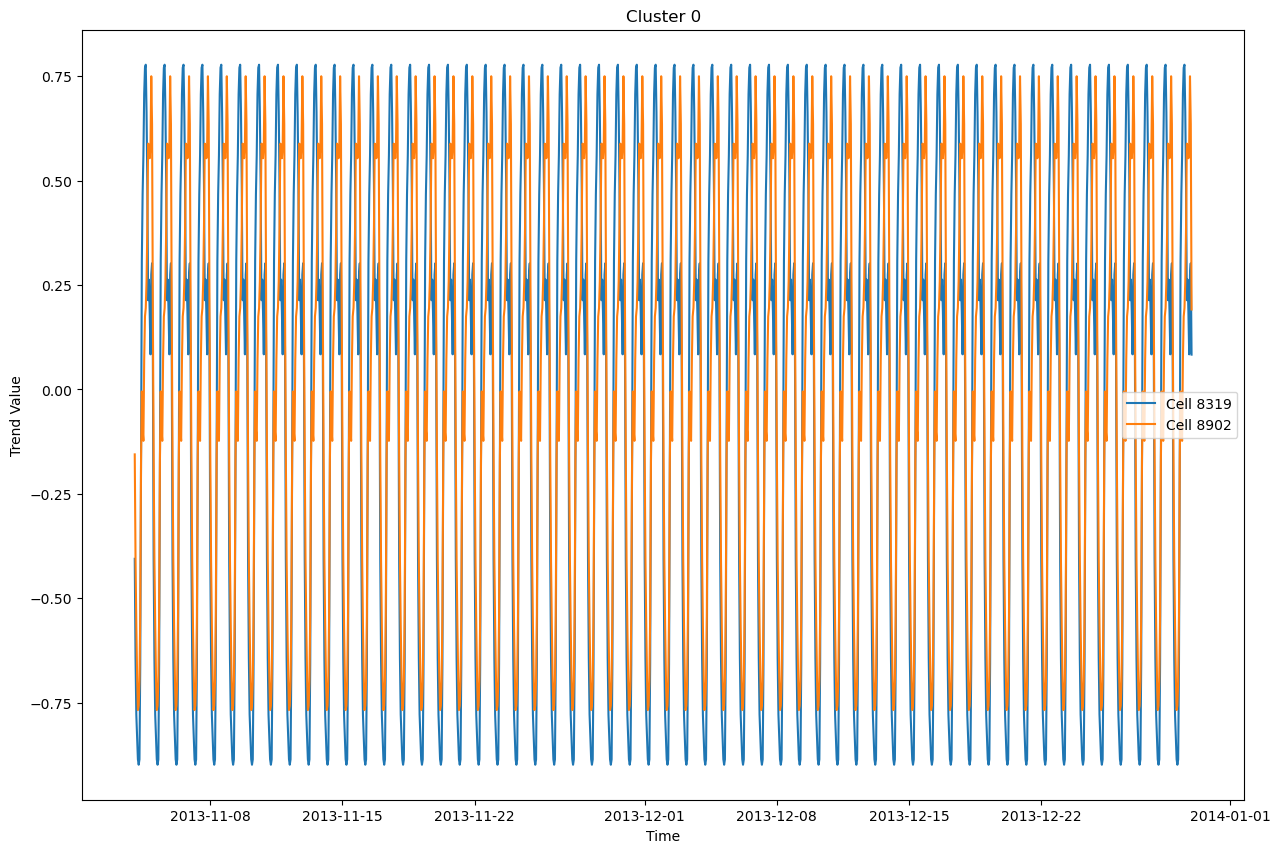

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# 유니크한 클러스터 라벨을 얻습니다.
unique_clusters = cell_labels['Cluster'].unique()

# 유니크한 클러스터 라벨 각각에 대해 그래프를 그립니다.
for cluster in unique_clusters:
    plt.figure(figsize=(15, 10))

    # 특정 클러스터에 속한 모든 셀들의 이름을 가져옵니다.
    selected_cells = cell_labels[cell_labels['Cluster'] == cluster]['Cell']

    # 가져온 셀 이름에 해당하는 열만 선택해서 그립니다.
    subset = decomposed_seasonal[selected_cells]
    
    for cell in selected_cells:
        plt.plot(subset[cell], label=f'Cell {cell}')
        
    plt.legend()
    plt.title(f'Cluster {cluster}')
    plt.xlabel('Time')
    plt.ylabel('Trend Value')
    plt.show()

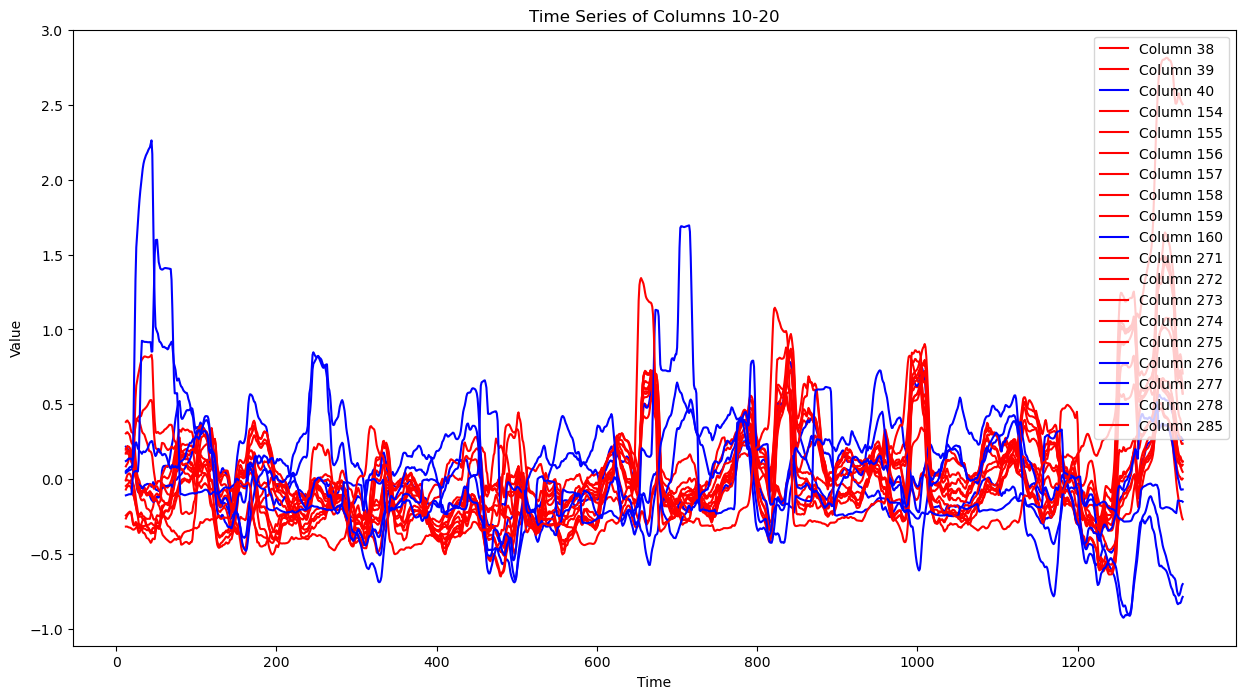

In [47]:
plt.figure(figsize=(15, 8))

for column in trend_labels.index[1:20]:    
    if trend_labels[column] == 'UP':
        color = 'r'  # 빨간색으로 그림
    elif trend_labels[column] == 'DOWN':
        color = 'b'  # 파란색으로 그림
    else:
        color = 'g'  # 나머지는 녹색으로 그림 (예시)
        
    plt.plot(decomposed_trend.index, decomposed_trend[column], label=f'Column {column}', color=color)

plt.title('Time Series of Columns 10-20')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.show()

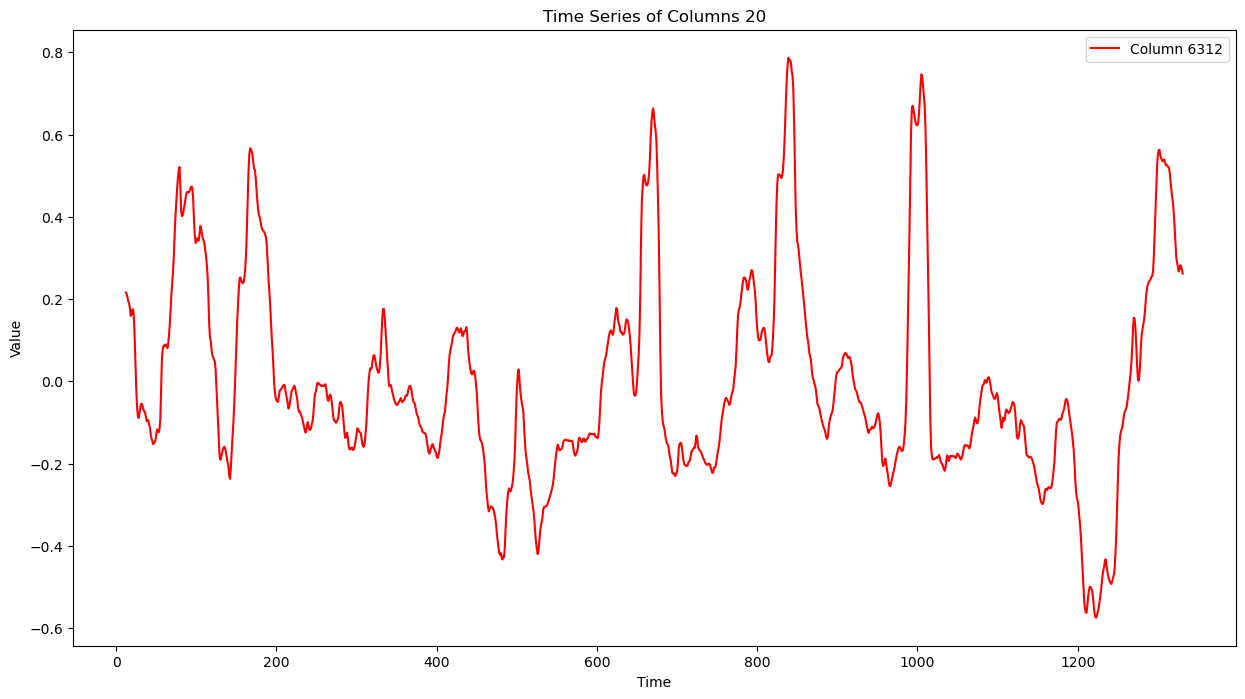

In [53]:
plt.figure(figsize=(15, 8))
plt.plot(decomposed_trend.index, decomposed_trend[40], label=f'Column {6312}', color=color)
plt.title('Time Series of Columns 20')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.show()

In [31]:
plt.figure(figsize=(15, 8))
plt.plot(normalized_df.index, normalized_df[6313], label=f'Column {6312}', color=color)
plt.title('Time Series of Columns 20')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.show()

KeyError: 6313

<Figure size 1500x800 with 0 Axes>

ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of ticklabels (121).

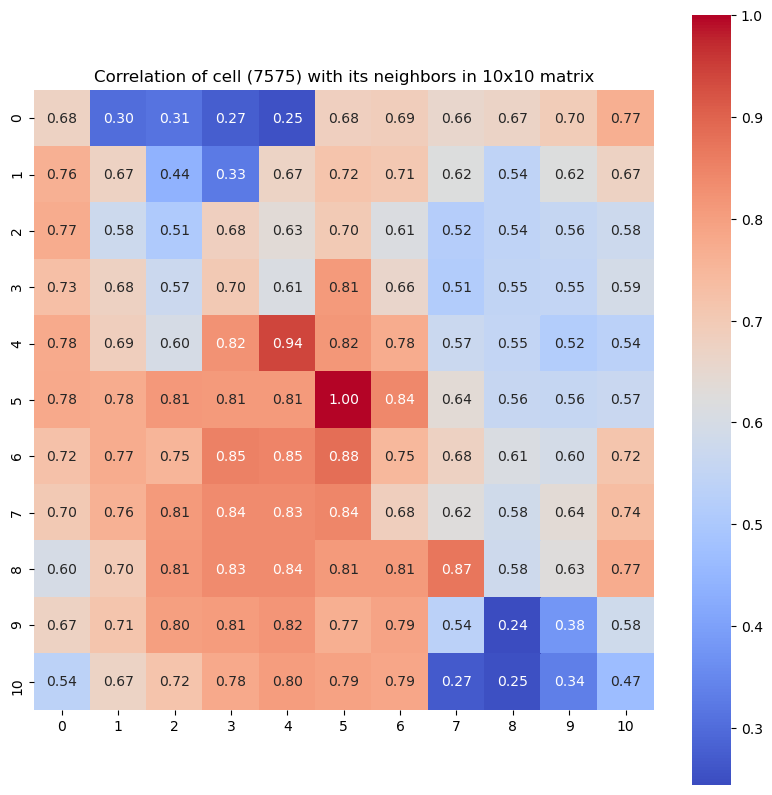

In [ ]:
# 대상 셀의 ID 지정
target_cell_id = 7575  # 예시 값

# 한 행에 몇 개의 셀이 있는지
cells_per_row = 100

# target_cell의 좌표 (i,j) 계산
i, j = divmod(target_cell_id - 1, cells_per_row)
i += 1
j += 1

# 주변 셀들의 위치 계산 (11x11 행렬)
neighbors = [(i + di, j + dj) for di in range(-5, 6) for dj in range(-5, 6)]
neighbors_ids = [(x - 1) * cells_per_row + y for x, y in neighbors]
neighbors_labels = [str(cell_id) for cell_id in neighbors_ids if cell_id in normalized_ori_df.columns]


# ori_df에 존재하는 컬럼만 골라냄
valid_ids = [cell_id for cell_id in neighbors_ids if cell_id in normalized_ori_df.columns]

# 대상 셀과 주변 셀들과의 상관관계 계산
correlations = normalized_ori_df.corr().loc[target_cell_id, valid_ids]

# 10x10 매트릭스 생성
correlation_matrix = np.full((11, 11), np.nan)

# target cell의 위치에 따른 주변 셀의 상관관계 설정
for cell_id in valid_ids:
    x, y = divmod(cell_id - 1, cells_per_row)
    x += 1
    y += 1
    dx = x - i
    dy = y - j
    if -5 <= dx <= 5 and -5 <= dy <= 5:  # 새로운 조건 추가
        if (dx, dy) == (0, 0):
            correlation_matrix[5, 5] = 1.0  # target cell 자신과의 상관관계는 1입니다.
        else:
            correlation_matrix[dx + 5, dy + 5] = correlations.get(cell_id, np.nan)



In [50]:
print(trend_labels)

1                                                       UP
2        ERROR: illegal value in 4-th argument of inter...
3                                                       UP
4        ERROR: illegal value in 4-th argument of inter...
5                                                     DOWN
                               ...                        
9996                                                  DOWN
9997     ERROR: illegal value in 4-th argument of inter...
9998     ERROR: illegal value in 4-th argument of inter...
9999                                                  DOWN
10000    ERROR: illegal value in 4-th argument of inter...
Length: 9953, dtype: object


In [33]:
print(decomposed_trend[column].isnull().any())
print(np.isinf(decomposed_trend[column]).any())

True
False


In [64]:
# 대상 셀과 주변 셀들과의 트렌드 상관관계 계산
trend_correlations = decomposed_trend.corr().loc[target_cell_id, valid_ids]

# 10x10 매트릭스 생성
trend_correlation_matrix = np.full((11, 11), np.nan)

# target cell의 위치에 따른 주변 셀의 상관관계 설정
for cell_id in valid_ids:
    x, y = divmod(cell_id - 1, cells_per_row)
    x += 1
    y += 1
    dx = x - i
    dy = y - j
    if -5 <= dx <= 5 and -5 <= dy <= 5:  # 새로운 조건 추가
        if (dx, dy) == (0, 0):
            trend_correlation_matrix[5, 5] = 1.0  # target cell 자신과의 상관관계는 1입니다.
        else:
            trend_correlation_matrix[dx + 5, dy + 5] = trend_correlations.get(cell_id, np.nan)

# 대상 셀과 주변 셀들과의 시즈널 상관관계 계산
seasonal_correlations = decomposed_seasonal.corr().loc[target_cell_id, valid_ids]

# 10x10 매트릭스 생성
seasonal_correlation_matrix = np.full((11, 11), np.nan)

# target cell의 위치에 따른 주변 셀의 상관관계 설정
for cell_id in valid_ids:
    x, y = divmod(cell_id - 1, cells_per_row)
    x += 1
    y += 1
    dx = x - i
    dy = y - j
    if -5 <= dx <= 5 and -5 <= dy <= 5:  # 새로운 조건 추가
        if (dx, dy) == (0, 0):
            seasonal_correlation_matrix[5, 5] = 1.0  # target cell 자신과의 상관관계는 1입니다.
        else:
            seasonal_correlation_matrix[dx + 5, dy + 5] = seasonal_correlations.get(cell_id, np.nan)

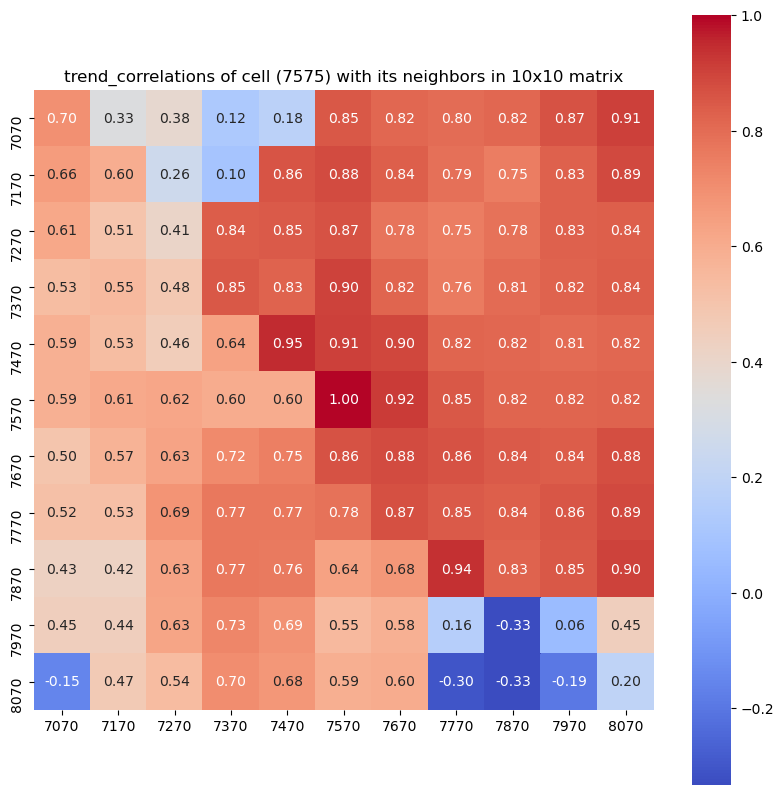

In [67]:

# 히트맵 그리기
plt.figure(figsize=(10,10))

# 이웃 셀들의 실제 cell ID 값을 tick 레이블로 사용
xticklabels = [str(cell_id) for i, cell_id in enumerate(neighbors_ids) if i % 11 == 0]
yticklabels = [str(cell_id) for i, cell_id in enumerate(neighbors_ids) if i % 11 == 0]

sns.heatmap(trend_correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True,
            fmt='.2f', annot_kws={'size': 10},
            xticklabels=xticklabels, yticklabels=yticklabels)
plt.title(f'trend_correlations of cell ({target_cell_id}) with its neighbors in 10x10 matrix')
# 히트맵과 상관계수 행렬 저장
plt.savefig(f'cell:{target_cell_id}_trend_corrleation_heatmap.png')
np.save(f'cell:{target_cell_id}_trend_correlation_matrix.npy', trend_correlation_matrix)


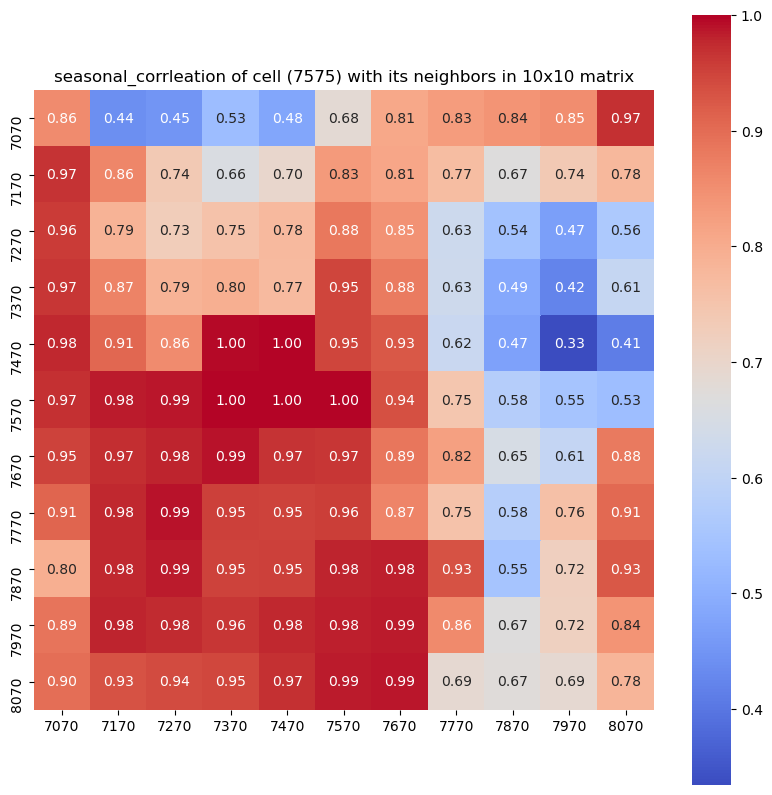

In [70]:

# 히트맵 그리기
plt.figure(figsize=(10,10))

# 이웃 셀들의 실제 cell ID 값을 tick 레이블로 사용
xticklabels = [str(cell_id) for i, cell_id in enumerate(neighbors_ids) if i % 11 == 0]
yticklabels = [str(cell_id) for i, cell_id in enumerate(neighbors_ids) if i % 11 == 0]

sns.heatmap(seasonal_correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True,
            fmt='.2f', annot_kws={'size': 10},
            xticklabels=xticklabels, yticklabels=yticklabels)
plt.title(f'seasonal_corrleation of cell ({target_cell_id}) with its neighbors in 10x10 matrix')
# 히트맵과 상관계수 행렬 저장
plt.savefig(f'cell:{target_cell_id}_seasonal_corrleation_heatmap.png')
np.save(f'cell:{target_cell_id}_seasonal_correlation_matrix.npy', seasonal_correlation_matrix)

In [108]:
base_cell = 7575
target_cell = 7474


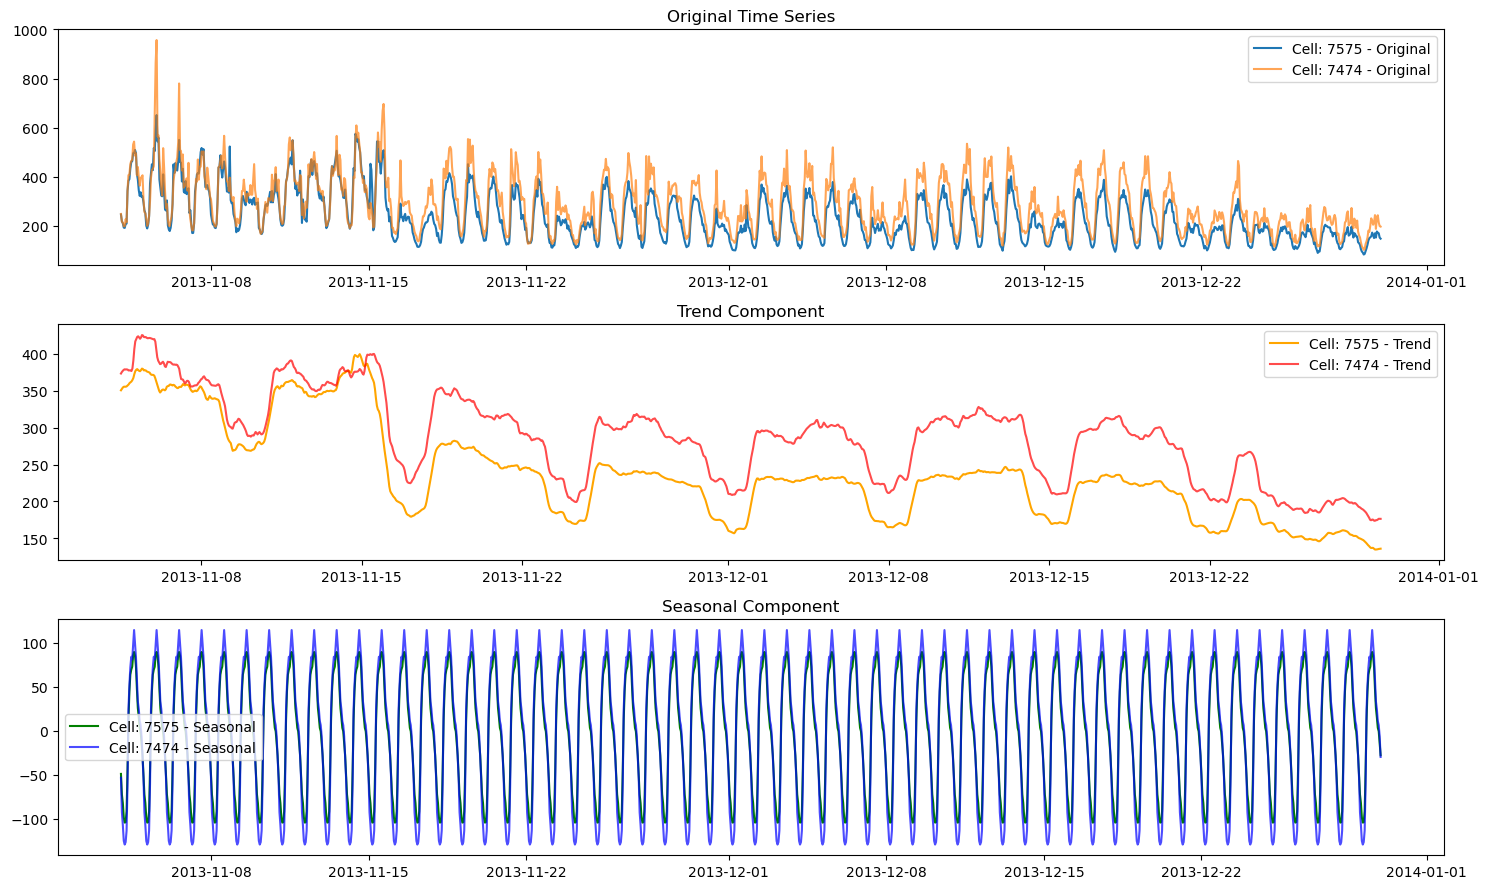

In [109]:
# ori_df, decomposed_trend, decomposed_seasonal이 DataFrame 형태라고 가정
ori_series_base_cell = ori_df[base_cell]
ori_series_target_cell = ori_df[target_cell]

trend_series_base_cell = decomposed_trend[base_cell]
trend_series_target_cell = decomposed_trend[target_cell]

seasonal_series_base_cell = decomposed_seasonal[base_cell]
seasonal_series_target_cell = decomposed_seasonal[target_cell]

plt.figure(figsize=(15, 9))

# Original Data
plt.subplot(3, 1, 1)
plt.plot(ori_series_base_cell.index, ori_series_base_cell.values, label=f'Cell: {base_cell} - Original')
plt.plot(ori_series_target_cell.index, ori_series_target_cell.values, label=f'Cell: {target_cell} - Original', alpha=0.7)
plt.title('Original Time Series')
plt.legend()

# Trend Component
plt.subplot(3, 1, 2)
plt.plot(trend_series_base_cell.index, trend_series_base_cell.values, label=f'Cell: {base_cell} - Trend', color='orange')
plt.plot(trend_series_target_cell.index, trend_series_target_cell.values, label=f'Cell: {target_cell} - Trend', color='red', alpha=0.7)
plt.title('Trend Component')
plt.legend()

# Seasonal Component
plt.subplot(3, 1, 3)
plt.plot(seasonal_series_base_cell.index, seasonal_series_base_cell.values, label=f'Cell: {base_cell} - Seasonal', color='green')
plt.plot(seasonal_series_target_cell.index, seasonal_series_target_cell.values, label=f'Cell: {target_cell} - Seasonal', color='blue', alpha=0.7)
plt.title('Seasonal Component')
plt.legend()

plt.tight_layout()
plt.show()

In [110]:
## Corr Value 확인

from scipy.stats import pearsonr

# NaN 값이 있는 행을 제거 (두 시리즈 모두 NaN이 아닌 경우만 남깁니다)
valid_indices = ori_series_base_cell.notna() & ori_series_target_cell.notna()
filtered_ori_series_base_cell = ori_series_base_cell[valid_indices]
filtered_ori_series_target_cell = ori_series_target_cell[valid_indices]  # 수정됨

# 이와 같은 작업을 Trend와 Seasonal 데이터에도 적용
valid_indices_trend = trend_series_base_cell.notna() & trend_series_target_cell.notna()
filtered_trend_series_base_cell = trend_series_base_cell[valid_indices_trend]
filtered_trend_series_target_cell = trend_series_target_cell[valid_indices_trend]  # 수정됨

valid_indices_seasonal = seasonal_series_base_cell.notna() & seasonal_series_target_cell.notna()
filtered_seasonal_series_base_cell = seasonal_series_base_cell[valid_indices_seasonal]
filtered_seasonal_series_target_cell = seasonal_series_target_cell[valid_indices_seasonal]  # 수정됨

# 상관계수 계산
corr_ori, _ = pearsonr(filtered_ori_series_base_cell, filtered_ori_series_target_cell)
corr_trend, _ = pearsonr(filtered_trend_series_base_cell, filtered_trend_series_target_cell)
corr_seasonal, _ = pearsonr(filtered_seasonal_series_base_cell, filtered_seasonal_series_target_cell)

print(f"Correlation between original data of cell {base_cell} and {target_cell}: {corr_ori}")
print(f"Correlation between trend component of cell {base_cell} and {target_cell}: {corr_trend}")
print(f"Correlation between seasonal component of cell {base_cell} and {target_cell}: {corr_seasonal}")


Correlation between original data of cell 7575 and 7474: 0.9425185150561073
Correlation between trend component of cell 7575 and 7474: 0.9499799050204738
Correlation between seasonal component of cell 7575 and 7474: 0.9974173359795065


In [19]:
configs = argparse.Namespace(
    seq_len = 72,
    pred_len = 1,
    kernel_size = 25,
    individual = False,
    enc_in = 1
)
global_model = DLinear.Model(configs).to(device)
global_up_trend_model = DLinear.Model(configs).to(device)
global_down_trend_model = DLinear.Model(configs).to(device)
global_model.train()
global_weights = global_model.state_dict()
# Save their state_dicts
global_up_trend_model_dict = global_up_trend_model.state_dict()
global_down_trend_model_dict = global_down_trend_model.state_dict()

train_df = new_df.iloc[:-24*7].copy()
test_df = new_df.iloc[-24*7:].copy()
test_df = restart_index(test_df)


In [20]:
train_x, train_y, train_date = time_slide_df(train_df, configs.seq_len, configs.pred_len)
test_x, test_y, test_date = time_slide_df(test_df, configs.seq_len, configs.pred_len)

cell_loss = []
loss_hist = []

In [21]:
global_up_trend_weights = []
global_down_trend_weights = []
global_seasonal_weights = []



In [22]:
up_trend_list = [7479,7080,7474]
down_trend_list = [8070,7073,8073]

In [23]:
for epoch in tqdm.tqdm(range(args.epochs)):
    local_weights, local_losses = [], []
    global_up_trend_weights, global_down_trend_weights, global_season_weights = [], [], []
    cell_loss, loss_hist = [], []
    global_model.train()

    for cell in sel_cell:
        cell_train_x, cell_train_y = train_x[cell], train_y[cell]
        cell_test_x, cell_test_y = test_x[cell], test_y[cell]
        
        local_model = LocalUpdate(args, cell_train_x, cell_train_y, cell_test_x, cell_test_y)

        if cell in up_trend_list:
            global_model.load_state_dict(global_up_trend_model_dict)
        elif cell in down_trend_list:
            global_model.load_state_dict(global_down_trend_model_dict)

        global_model.train()

        w, loss, epoch_loss = local_model.update_weights_new(model=copy.deepcopy(global_model), global_round=epoch)

        if cell in up_trend_list:
            global_up_trend_weights.append(copy.deepcopy(w['Linear_Trend.weight']))
        elif cell in down_trend_list:
            global_down_trend_weights.append(copy.deepcopy(w['Linear_Trend.weight']))

        global_season_weights.append(copy.deepcopy(w['Linear_Seasonal.weight']))

        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))
        cell_loss.append(loss)

    loss_hist.append(sum(cell_loss) / len(cell_loss))
    # Calculate and print the average loss for this epoch
    avg_loss = sum(local_losses) / len(local_losses)
    print(f"Average loss for epoch {epoch+1}: {avg_loss}")
    
    # Update global models
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

    global_up_trend_avg_weights = average_tensors(global_up_trend_weights)
    global_down_trend_avg_weights = average_tensors(global_down_trend_weights)

    # Retrieve the current 'Linear_Seasonal.weight' from global_weights
    current_global_seasonal_weight = global_weights['Linear_Seasonal.weight']
    
    # Update only the 'Linear_Trend.weight' field in the state_dict for up_trend and down_trend models
    global_up_trend_model_dict['Linear_Trend.weight'] = global_up_trend_avg_weights
    global_up_trend_model_dict['Linear_Seasonal.weight'] = current_global_seasonal_weight  # Use global seasonal weight

    global_down_trend_model_dict['Linear_Trend.weight'] = global_down_trend_avg_weights
    global_down_trend_model_dict['Linear_Seasonal.weight'] = current_global_seasonal_weight  # Use global seasonal weight


    # Load the updated state_dict into the models
    global_up_trend_model
    global_up_trend_model.load_state_dict(global_up_trend_model_dict)
    global_down_trend_model.load_state_dict(global_down_trend_model_dict)


  4%|▍         | 4/100 [00:00<00:05, 17.85it/s]

Average loss for epoch 1: 0.9943801590374538
Average loss for epoch 2: 0.526399131332125
Average loss for epoch 3: 0.40983041908059803
Average loss for epoch 4: 0.35310893612248556


  8%|▊         | 8/100 [00:00<00:05, 18.26it/s]

Average loss for epoch 5: 0.3214518300124577
Average loss for epoch 6: 0.3010965905019215
Average loss for epoch 7: 0.2862161717244557
Average loss for epoch 8: 0.2742651275226048


 10%|█         | 10/100 [00:00<00:04, 18.28it/s]

Average loss for epoch 9: 0.2640926454748426
Average loss for epoch 10: 0.2551489898136684
Average loss for epoch 11: 0.2471480177981513


 14%|█▍        | 14/100 [00:00<00:05, 15.72it/s]

Average loss for epoch 12: 0.2399222446339471
Average loss for epoch 13: 0.23336022240774973
Average loss for epoch 14: 0.22737914323806763
Average loss for epoch 15: 0.2219125373022897


 18%|█▊        | 18/100 [00:01<00:04, 17.09it/s]

Average loss for epoch 16: 0.21690443796770914
Average loss for epoch 17: 0.212306518639837
Average loss for epoch 18: 0.20807648982320512
Average loss for epoch 19: 0.20417700920786178


 22%|██▏       | 22/100 [00:01<00:04, 17.49it/s]

Average loss for epoch 20: 0.20057505049875804
Average loss for epoch 21: 0.1972412530864988
Average loss for epoch 22: 0.1941495133297784
Average loss for epoch 23: 0.19127660883324488


 26%|██▌       | 26/100 [00:01<00:04, 18.05it/s]

Average loss for epoch 24: 0.18860180995294026
Average loss for epoch 25: 0.18610662647656032
Average loss for epoch 26: 0.1837745447243963
Average loss for epoch 27: 0.1815907997744424


 30%|███       | 30/100 [00:01<00:03, 18.25it/s]

Average loss for epoch 28: 0.17954215300934656
Average loss for epoch 29: 0.17761677716459548
Average loss for epoch 30: 0.1758040264248848
Average loss for epoch 31: 0.1740943661757878


 34%|███▍      | 34/100 [00:01<00:03, 18.39it/s]

Average loss for epoch 32: 0.17247922399214335
Average loss for epoch 33: 0.1709508587207113
Average loss for epoch 34: 0.16950232748474395
Average loss for epoch 35: 0.16812735476664134


 38%|███▊      | 38/100 [00:02<00:03, 18.48it/s]

Average loss for epoch 36: 0.16682026322398866
Average loss for epoch 37: 0.16557592366422927
Average loss for epoch 38: 0.16438969756875718
Average loss for epoch 39: 0.16325736897332327


 42%|████▏     | 42/100 [00:02<00:03, 18.54it/s]

Average loss for epoch 40: 0.16217512105192458
Average loss for epoch 41: 0.16113948609147752
Average loss for epoch 42: 0.16014728269406728
Average loss for epoch 43: 0.15919562854937144


 46%|████▌     | 46/100 [00:02<00:02, 18.52it/s]

Average loss for epoch 44: 0.15828190850360052
Average loss for epoch 45: 0.1574037021824292
Average loss for epoch 46: 0.15655880208526338
Average loss for epoch 47: 0.15574520294155395


 50%|█████     | 50/100 [00:02<00:02, 18.52it/s]

Average loss for epoch 48: 0.154961031462465
Average loss for epoch 49: 0.1542045995593071
Average loss for epoch 50: 0.15347432983773096
Average loss for epoch 51: 0.15276877262762614


 54%|█████▍    | 54/100 [00:03<00:02, 18.53it/s]

Average loss for epoch 52: 0.15208658682448523
Average loss for epoch 53: 0.15142654095377242
Average loss for epoch 54: 0.15078749081918172
Average loss for epoch 55: 0.15016837418079376


 58%|█████▊    | 58/100 [00:03<00:02, 18.54it/s]

Average loss for epoch 56: 0.1495681947895459
Average loss for epoch 57: 0.14898605006081717
Average loss for epoch 58: 0.14842107253415243
Average loss for epoch 59: 0.1478724724480084


 62%|██████▏   | 62/100 [00:03<00:02, 16.06it/s]

Average loss for epoch 60: 0.14733949303627014
Average loss for epoch 61: 0.14682144778115408
Average loss for epoch 62: 0.14631769061088562
Average loss for epoch 63: 0.14582758929048265


 66%|██████▌   | 66/100 [00:03<00:01, 17.10it/s]

Average loss for epoch 64: 0.14535058928387506
Average loss for epoch 65: 0.14488614137683595
Average loss for epoch 66: 0.1444337336080415
Average loss for epoch 67: 0.1439928976552827


 70%|███████   | 70/100 [00:03<00:01, 17.82it/s]

Average loss for epoch 68: 0.14356317690440587
Average loss for epoch 69: 0.14314414028610503
Average loss for epoch 70: 0.14273537801844732
Average loss for epoch 71: 0.1423365335379328


 74%|███████▍  | 74/100 [00:04<00:01, 18.18it/s]

Average loss for epoch 72: 0.141947226864951
Average loss for epoch 73: 0.14156710995095118
Average loss for epoch 74: 0.1411958709359169
Average loss for epoch 75: 0.14083318731614522


 78%|███████▊  | 78/100 [00:04<00:01, 18.35it/s]

Average loss for epoch 76: 0.1404787770339421
Average loss for epoch 77: 0.14013234632355825
Average loss for epoch 78: 0.13979364186525345
Average loss for epoch 79: 0.1394623943737575


 82%|████████▏ | 82/100 [00:04<00:00, 18.45it/s]

Average loss for epoch 80: 0.13913837181670324
Average loss for epoch 81: 0.13882134216172354
Average loss for epoch 82: 0.13851107444081986
Average loss for epoch 83: 0.13820736642394746


 86%|████████▌ | 86/100 [00:04<00:00, 18.44it/s]

Average loss for epoch 84: 0.13791001800979888
Average loss for epoch 85: 0.13761881526027406
Average loss for epoch 86: 0.13733359426259995
Average loss for epoch 87: 0.1370541559798377


 90%|█████████ | 90/100 [00:05<00:00, 18.51it/s]

Average loss for epoch 88: 0.13678035246474401
Average loss for epoch 89: 0.13651199958154134
Average loss for epoch 90: 0.13624894725424902
Average loss for epoch 91: 0.13599103902067458


 94%|█████████▍| 94/100 [00:05<00:00, 18.54it/s]

Average loss for epoch 92: 0.1357381386416299
Average loss for epoch 93: 0.1354900917836598
Average loss for epoch 94: 0.13524678349494934
Average loss for epoch 95: 0.13500806795699255


 98%|█████████▊| 98/100 [00:05<00:00, 18.53it/s]

Average loss for epoch 96: 0.134773816381182
Average loss for epoch 97: 0.13454392020191466
Average loss for epoch 98: 0.13431825382368906
Average loss for epoch 99: 0.13409671080963953


100%|██████████| 100/100 [00:05<00:00, 17.90it/s]

Average loss for epoch 100: 0.13387918365853174


In [247]:

for epoch in tqdm.tqdm(range(args.epochs)):
    local_weights, local_losses = [], []
    # print(f'\n | Global Training Round: {epoch+1} |\n')
    global_model.train()

    for cell in sel_cell:
        cell_train_x, cell_train_y = train_x[cell], train_y[cell]
        cell_test_x, cell_test_y = test_x[cell], test_y[cell]

        local_model = LocalUpdate(args, cell_train_x, cell_train_y, cell_test_x, cell_test_y)

        if cell in up_trend_list:
            global_model.load_state_dict(global_up_trend_model_dict())  
        elif cell in down_trend_list:
            global_model.load_state_dict(global_down_trend_model_dict())  

        #global_model.load_state_dict(global_weights)
        global_model.train()

        w, loss, epoch_loss = local_model.update_weights_new(model=copy.deepcopy(global_model),
                                                            global_round=epoch)

        if cell in up_trend_list:
            global_up_trend_weights.append(copy.deepcopy(w['Linear_Trend.weight']))
        elif cell in down_trend_list:
            global_down_trend_weights.append(copy.deepcopy(w['Linear_Trend.weight']))


        global_season_weights.append(copy.deepcopy(w['Linear_Seasonal.weight']))

        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))
        cell_loss.append(loss)
    loss_hist.append(sum(cell_loss)/len(cell_loss))
    
    # Update global model (Up_Trend, Down_Trend)
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

    global_up_trend_model.load_state_dict(global_weights['Linear_Trend.weight'] 
    = average_weights(global_up_trend_weights) )
    global_down_trend_model.load_state_dict(global_weights['Linear_Trend.weight'] 
    = average_weights(global_down_trend_weights) )
    


100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


In [24]:
print(f"loss:{loss}\n epoch_loss{epoch_loss}")

loss:0.16601073741912842
 epoch_loss[0.16601073741912842]


In [25]:
# Test model accuracy
pred, truth = {}, {}
test_loss_list = []
test_mse_list = []
nrmse = 0.0

# Initialize empty dataframes for predictions and truths
df_pred = pd.DataFrame()
df_truth = pd.DataFrame()

for cell in sel_cell:
    cell_test_x, cell_test_y = test_x[cell], test_y[cell]
    
    # Choose the appropriate global model based on the trend of the cell
    if cell in up_trend_list:
        global_model.load_state_dict(global_up_trend_model_dict)
    elif cell in down_trend_list:
        global_model.load_state_dict(global_down_trend_model_dict)
    
    # Perform inference
    test_loss, test_mse, test_nrmse, pred[cell], truth[cell] = test_inference_new(args, global_model, cell_test_x, cell_test_y)
    
    # Print and accumulate metrics
    print(f'Cell {cell} MSE {test_mse:.4f}')
    nrmse += test_nrmse
    test_loss_list.append(test_loss)
    test_mse_list.append(test_mse)
    
    # Append the current predictions and truths to the dataframes
    df_pred[cell] = pred[cell]
    df_truth[cell] = truth[cell]

# Calculate global metrics
mse = metrics.mean_squared_error(df_pred.values.ravel(), df_truth.values.ravel())
mae = metrics.mean_absolute_error(df_pred.values.ravel(), df_truth.values.ravel())
nrmse = nrmse / len(sel_cell)  # Note: Make sure to change `selected_cells` to `sel_cell` if that's what you're using

print('FedAvg File: {:} Type: {:} MSE: {:.4f} MAE: {:.4f}, NRMSE: {:.4f}'.format(args.file, args.type, mse, mae, nrmse))


Cell 7575 MSE 0.0141
Cell 7479 MSE 0.0109
Cell 7080 MSE 0.0103
Cell 8070 MSE 0.0754
Cell 7073 MSE 0.0414
Cell 8073 MSE 0.0443
Cell 7474 MSE 0.0546
FedAvg File: milano.h5 Type: net MSE: 0.0359 MAE: 0.1424, NRMSE: 0.2020


In [250]:
# Update global model
global_weights = average_weights(local_weights)
global_model.load_state_dict(global_weights)

# Test model accuracy
pred, truth = {}, {}
test_loss_list = []
test_mse_list = []
nrmse = 0.0

global_model.load_state_dict(global_weights)

for cell in sel_cell:
    cell_test_x, cell_test_y = test_x[cell], test_y[cell]
    test_loss, test_mse, test_nrmse, pred[cell], truth[cell] = test_inference_new(args, global_model, cell_test_x, cell_test_y)
    print(f'Cell {cell} MSE {test_mse:.4f}')
    nrmse += test_nrmse
    test_loss_list.append(test_loss)
    test_mse_list.append(test_mse)

df_pred = pd.DataFrame.from_dict(pred)
df_truth = pd.DataFrame.from_dict(truth)

mse = metrics.mean_squared_error(df_pred.values.ravel(), df_truth.values.ravel())
mae = metrics.mean_absolute_error(df_pred.values.ravel(), df_truth.values.ravel())
nrmse = nrmse / len(selected_cells)
print('FedAvg File: {:} Type: {:} MSE: {:.4f} MAE: {:.4f}, NRMSE: {:.4f}'.format(args.file, args.type, mse, mae,
                                                                                    nrmse))


Cell 7575 MSE 0.0178
Cell 7479 MSE 0.0016
Cell 7080 MSE 0.0016
Cell 8070 MSE 0.1099
Cell 7073 MSE 0.0484
Cell 8073 MSE 0.0540
Cell 7474 MSE 0.0499
FedAvg File: milano.h5 Type: net MSE: 0.0402 MAE: 0.1367, NRMSE: 0.0092


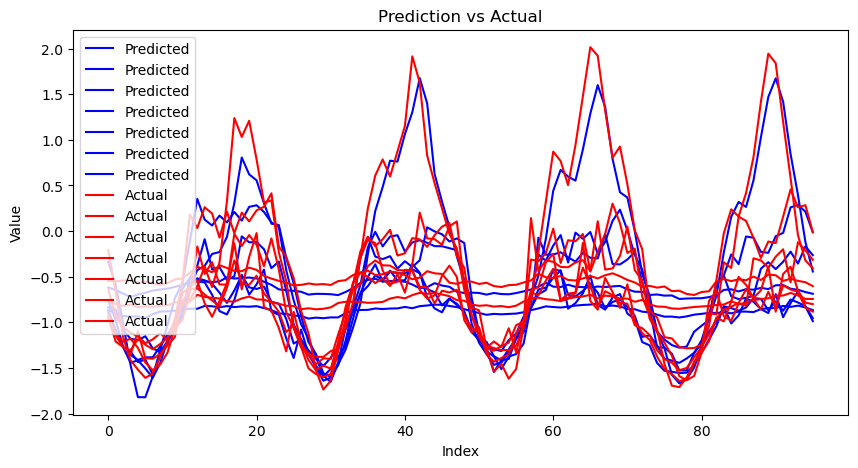

In [26]:
# 예측값과 실제값을 그래프에 표현
plt.figure(figsize=(10, 5))

# 예측값 그래프 (파란색)
plt.plot(df_pred.index, df_pred.values, label='Predicted', color='blue')

# 실제값 그래프 (빨간색)
plt.plot(df_truth.index, df_truth.values, label='Actual', color='red')

plt.title('Prediction vs Actual')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.show()

In [51]:
import plotly.graph_objects as go
import numpy as np

# 샘플 데이터 생성
n = 10
x = np.tile(np.linspace(0, 10, n), n)
y = np.repeat(np.linspace(0, 10, n), n)
z = np.random.rand(n * n) * 100  # 트래픽 양을 임의로 생성

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=3,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# 축 레이블 설정
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Traffic'
))

fig.show()


In [22]:
selected_cells


[35,
 157,
 214,
 370,
 383,
 436,
 484,
 495,
 504,
 521,
 585,
 732,
 1053,
 1436,
 1557,
 1658,
 1694,
 1788,
 1951,
 2000,
 2221,
 2702,
 2782,
 2811,
 2854,
 3065,
 3130,
 3288,
 3459,
 3568,
 3604,
 3652,
 3738,
 3768,
 3802,
 3823,
 3838,
 3997,
 4199,
 4384,
 4691,
 4788,
 4897,
 5012,
 5097,
 5244,
 5498,
 5681,
 5711,
 5836,
 6062,
 6118,
 6187,
 6267,
 6293,
 6434,
 6491,
 6492,
 6496,
 6671,
 6674,
 6836,
 6866,
 6963,
 7138,
 7222,
 7239,
 7345,
 7412,
 7578,
 7737,
 7785,
 7916,
 8041,
 8071,
 8165,
 8171,
 8229,
 8253,
 8276,
 8326,
 8366,
 8378,
 8465,
 8583,
 8692,
 8889,
 8918,
 9031,
 9039,
 9106,
 9164,
 9373,
 9514,
 9520,
 9674,
 9698,
 9733,
 9766,
 10000]

In [23]:
def closest_pairs(nums):
    # 연속된 두 요소 간의 차이를 계산
    differences = [nums[i+1] - nums[i] for i in range(len(nums) - 1)]
    
    # 최소 차이 찾기
    min_diff = min(differences)

    # 최소 차이를 가지는 모든 숫자 쌍과 그들의 인덱스 찾기
    pairs_and_indices = [((nums[i], nums[i+1]), (i, i+1)) for i, diff in enumerate(differences) if diff == min_diff]

    return pairs_and_indices

In [24]:
print(closest_pairs(selected_cells))

[((6491, 6492), (56, 57))]


In [30]:
lng = cell_lng[56]
lat = cell_lat[56]
lng2 = cell_lng[57]
lat2 = cell_lat[57]

In [31]:
po1 = (lat,lng)
po2 = (lat2,lng2)
po2

(45.49276327547867, 9.286708683940935)

In [34]:
type(ori_df[6491])

pandas.core.series.Series

In [35]:
correlation = ori_df[6491].corr(ori_df[6492])

print(correlation)


0.5763223016791171


In [7]:
df,ori_df,df_s,_,_,_,_ = get_data("milano.h5")

AttributeError: 'str' object has no attribute 'file'

In [48]:
df_reset = df.reset_index()
df_reset = df_reset.rename(columns={'index': 'date_time'})

train_df = df_reset.iloc[:-24*7].copy()
test_df = df_reset.iloc[-24*7:].copy()
test_df = restart_index(test_df)

In [49]:
targets=1012

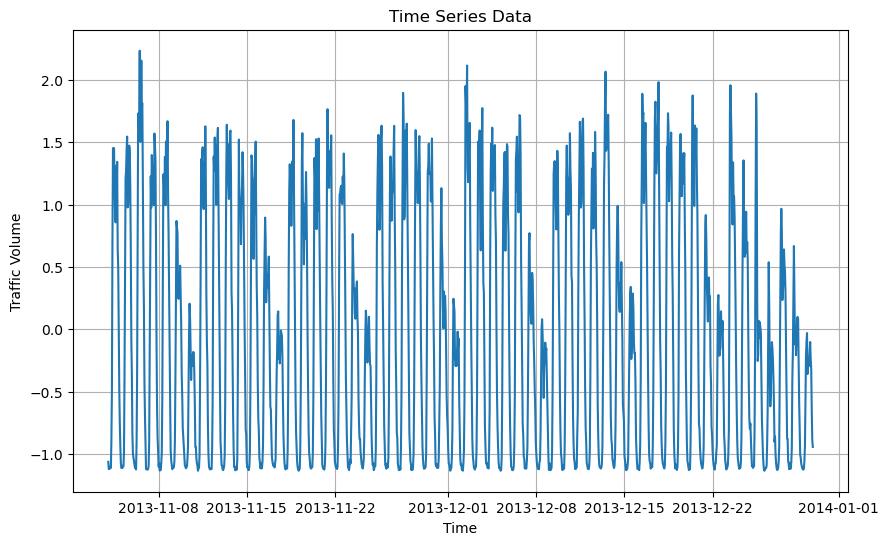

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(df_reset['date_time'], df_reset[targets])
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.title('Time Series Data')
plt.grid(True)
plt.show()

In [60]:
### Univariable ###
### 데이터 셋 생성 ###
window_size = 72
forcast_size= 3
batch_size = 20
targets = 1012
date = 'date_time'

#train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, 'date_time', targets)
#def time_slide_df(df, window_size, forcast_size, date, target):
    
train_x, train_y, train_date = time_slide_df(train_df, window_size, forcast_size, date, targets)
test_x, test_y, test_date = time_slide_df(test_df, window_size, forcast_size, date, targets)


In [61]:
train_ds = Data(train_x[:1000], train_y[:1000])
valid_ds = Data(train_x[1000:], train_y[1000:])
test_ds = Data(test_x, test_y)

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,)

valid_dl = DataLoader(valid_ds, batch_size = train_x[1000:].shape[0], shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)

In [62]:

### DLinear 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 200
lr = 0.001
DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
        
        for data, target in test_dl:
            output = DLinear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  2%|█▎                                                                | 4/200 [00:00<00:10, 18.67it/s]

valid_loss=0.178, test_los0.156, Model Save
epoch = 1, train_loss : 0.357, valid_loss : 0.178, test_loss : 0.156
valid_loss=0.126, test_los0.132, Model Save
epoch = 2, train_loss : 0.166, valid_loss : 0.126, test_loss : 0.132
valid_loss=0.097, test_los0.116, Model Save
epoch = 3, train_loss : 0.130, valid_loss : 0.097, test_loss : 0.116
valid_loss=0.082, test_los0.106, Model Save
epoch = 4, train_loss : 0.112, valid_loss : 0.082, test_loss : 0.106


  4%|██▋                                                               | 8/200 [00:00<00:09, 19.34it/s]

valid_loss=0.079, test_los0.102, Model Save
epoch = 5, train_loss : 0.101, valid_loss : 0.079, test_loss : 0.102
epoch = 6, train_loss : 0.093, valid_loss : 0.081, test_loss : 0.106
valid_loss=0.071, test_los0.088, Model Save
epoch = 7, train_loss : 0.088, valid_loss : 0.071, test_loss : 0.088
valid_loss=0.066, test_los0.090, Model Save
epoch = 8, train_loss : 0.083, valid_loss : 0.066, test_loss : 0.090


  6%|███▉                                                             | 12/200 [00:00<00:09, 19.59it/s]

valid_loss=0.065, test_los0.076, Model Save
epoch = 9, train_loss : 0.079, valid_loss : 0.065, test_loss : 0.076
valid_loss=0.059, test_los0.078, Model Save
epoch = 10, train_loss : 0.078, valid_loss : 0.059, test_loss : 0.078
epoch = 11, train_loss : 0.076, valid_loss : 0.067, test_loss : 0.089
epoch = 12, train_loss : 0.074, valid_loss : 0.063, test_loss : 0.082


  8%|█████▏                                                           | 16/200 [00:00<00:09, 19.74it/s]

valid_loss=0.057, test_los0.077, Model Save
epoch = 13, train_loss : 0.072, valid_loss : 0.057, test_loss : 0.077
epoch = 14, train_loss : 0.071, valid_loss : 0.062, test_loss : 0.069
epoch = 15, train_loss : 0.070, valid_loss : 0.059, test_loss : 0.070
epoch = 16, train_loss : 0.069, valid_loss : 0.062, test_loss : 0.074
epoch = 17, train_loss : 0.068, valid_loss : 0.059, test_loss : 0.063


 10%|██████▌                                                          | 20/200 [00:01<00:09, 19.80it/s]

epoch = 18, train_loss : 0.067, valid_loss : 0.060, test_loss : 0.077
epoch = 19, train_loss : 0.067, valid_loss : 0.058, test_loss : 0.074
valid_loss=0.056, test_los0.078, Model Save
epoch = 20, train_loss : 0.067, valid_loss : 0.056, test_loss : 0.078
epoch = 21, train_loss : 0.066, valid_loss : 0.058, test_loss : 0.066


 12%|███████▊                                                         | 24/200 [00:01<00:08, 19.79it/s]

valid_loss=0.055, test_los0.066, Model Save
epoch = 22, train_loss : 0.065, valid_loss : 0.055, test_loss : 0.066
epoch = 23, train_loss : 0.066, valid_loss : 0.056, test_loss : 0.065
valid_loss=0.054, test_los0.070, Model Save
epoch = 24, train_loss : 0.066, valid_loss : 0.054, test_loss : 0.070
epoch = 25, train_loss : 0.066, valid_loss : 0.056, test_loss : 0.069


 14%|█████████                                                        | 28/200 [00:01<00:08, 19.87it/s]

epoch = 26, train_loss : 0.064, valid_loss : 0.062, test_loss : 0.079
epoch = 27, train_loss : 0.065, valid_loss : 0.057, test_loss : 0.065
epoch = 28, train_loss : 0.064, valid_loss : 0.057, test_loss : 0.064
epoch = 29, train_loss : 0.064, valid_loss : 0.058, test_loss : 0.061
valid_loss=0.053, test_los0.065, Model Save


 17%|███████████                                                      | 34/200 [00:01<00:08, 19.91it/s]

epoch = 30, train_loss : 0.064, valid_loss : 0.053, test_loss : 0.065
epoch = 31, train_loss : 0.063, valid_loss : 0.061, test_loss : 0.077
epoch = 32, train_loss : 0.063, valid_loss : 0.057, test_loss : 0.078
epoch = 33, train_loss : 0.063, valid_loss : 0.054, test_loss : 0.058
epoch = 34, train_loss : 0.063, valid_loss : 0.060, test_loss : 0.065


 19%|████████████▎                                                    | 38/200 [00:01<00:08, 19.89it/s]

epoch = 35, train_loss : 0.063, valid_loss : 0.055, test_loss : 0.065
valid_loss=0.053, test_los0.061, Model Save
epoch = 36, train_loss : 0.063, valid_loss : 0.053, test_loss : 0.061
epoch = 37, train_loss : 0.063, valid_loss : 0.055, test_loss : 0.068
epoch = 38, train_loss : 0.063, valid_loss : 0.054, test_loss : 0.066


 21%|█████████████▋                                                   | 42/200 [00:02<00:07, 19.90it/s]

epoch = 39, train_loss : 0.062, valid_loss : 0.057, test_loss : 0.063
epoch = 40, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.067
epoch = 41, train_loss : 0.062, valid_loss : 0.055, test_loss : 0.067
epoch = 42, train_loss : 0.063, valid_loss : 0.058, test_loss : 0.062
epoch = 43, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.066


 24%|███████████████▌                                                 | 48/200 [00:02<00:07, 19.91it/s]

epoch = 44, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.074
epoch = 45, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.063
epoch = 46, train_loss : 0.062, valid_loss : 0.060, test_loss : 0.063
epoch = 47, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.074
epoch = 48, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.069


 26%|████████████████▉                                                | 52/200 [00:02<00:07, 19.91it/s]

epoch = 49, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.057
epoch = 50, train_loss : 0.062, valid_loss : 0.054, test_loss : 0.065
epoch = 51, train_loss : 0.062, valid_loss : 0.057, test_loss : 0.070
epoch = 52, train_loss : 0.063, valid_loss : 0.055, test_loss : 0.073
epoch = 53, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.065


 28%|██████████████████▏                                              | 56/200 [00:02<00:07, 19.89it/s]

epoch = 54, train_loss : 0.062, valid_loss : 0.066, test_loss : 0.065
epoch = 55, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.068
epoch = 56, train_loss : 0.061, valid_loss : 0.063, test_loss : 0.069
epoch = 57, train_loss : 0.062, valid_loss : 0.059, test_loss : 0.062
epoch = 58, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.058


 31%|████████████████████▏                                            | 62/200 [00:03<00:06, 19.85it/s]

epoch = 59, train_loss : 0.062, valid_loss : 0.055, test_loss : 0.064
epoch = 60, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.069
epoch = 61, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.066
epoch = 62, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.065


 33%|█████████████████████▍                                           | 66/200 [00:03<00:06, 19.83it/s]

epoch = 63, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.066
epoch = 64, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.072
epoch = 65, train_loss : 0.062, valid_loss : 0.055, test_loss : 0.076
epoch = 66, train_loss : 0.061, valid_loss : 0.065, test_loss : 0.072


 35%|██████████████████████▊                                          | 70/200 [00:03<00:06, 19.82it/s]

epoch = 67, train_loss : 0.063, valid_loss : 0.067, test_loss : 0.070
epoch = 68, train_loss : 0.063, valid_loss : 0.057, test_loss : 0.075
epoch = 69, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.065
epoch = 70, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.080


 37%|████████████████████████                                         | 74/200 [00:03<00:06, 19.83it/s]

epoch = 71, train_loss : 0.061, valid_loss : 0.063, test_loss : 0.077
epoch = 72, train_loss : 0.061, valid_loss : 0.060, test_loss : 0.073
epoch = 73, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.072
epoch = 74, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.058


 39%|█████████████████████████▎                                       | 78/200 [00:03<00:06, 19.83it/s]

epoch = 75, train_loss : 0.061, valid_loss : 0.060, test_loss : 0.065
epoch = 76, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.059
epoch = 77, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.064
epoch = 78, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.066


 41%|██████████████████████████▋                                      | 82/200 [00:04<00:05, 19.84it/s]

epoch = 79, train_loss : 0.062, valid_loss : 0.057, test_loss : 0.068
epoch = 80, train_loss : 0.061, valid_loss : 0.059, test_loss : 0.061
epoch = 81, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.077
epoch = 82, train_loss : 0.060, valid_loss : 0.062, test_loss : 0.076


 43%|███████████████████████████▉                                     | 86/200 [00:04<00:05, 19.85it/s]

epoch = 83, train_loss : 0.061, valid_loss : 0.059, test_loss : 0.063
epoch = 84, train_loss : 0.061, valid_loss : 0.063, test_loss : 0.065
epoch = 85, train_loss : 0.062, valid_loss : 0.056, test_loss : 0.065
epoch = 86, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.068


 45%|█████████████████████████████▎                                   | 90/200 [00:04<00:05, 19.84it/s]

epoch = 87, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.072
epoch = 88, train_loss : 0.061, valid_loss : 0.053, test_loss : 0.062
epoch = 89, train_loss : 0.062, valid_loss : 0.055, test_loss : 0.058
epoch = 90, train_loss : 0.062, valid_loss : 0.054, test_loss : 0.060


 47%|██████████████████████████████▌                                  | 94/200 [00:04<00:05, 19.86it/s]

epoch = 91, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.064
epoch = 92, train_loss : 0.060, valid_loss : 0.062, test_loss : 0.071
epoch = 93, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.066
epoch = 94, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.056


 49%|███████████████████████████████▊                                 | 98/200 [00:04<00:05, 19.88it/s]

epoch = 95, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.069
epoch = 96, train_loss : 0.061, valid_loss : 0.061, test_loss : 0.078
epoch = 97, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.067
epoch = 98, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.062
epoch = 99, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.059


 52%|█████████████████████████████████▎                              | 104/200 [00:05<00:04, 19.89it/s]

epoch = 100, train_loss : 0.061, valid_loss : 0.060, test_loss : 0.073
epoch = 101, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.082
epoch = 102, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.061
epoch = 103, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.066
epoch = 104, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.075


 54%|██████████████████████████████████▌                             | 108/200 [00:05<00:04, 19.89it/s]

epoch = 105, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.065
epoch = 106, train_loss : 0.060, valid_loss : 0.067, test_loss : 0.082
epoch = 107, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.068
epoch = 108, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.070


 56%|███████████████████████████████████▊                            | 112/200 [00:05<00:04, 19.90it/s]

epoch = 109, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.075
epoch = 110, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.066
epoch = 111, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.057
epoch = 112, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.071
epoch = 113, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.067


 59%|█████████████████████████████████████▊                          | 118/200 [00:05<00:04, 19.92it/s]

epoch = 114, train_loss : 0.060, valid_loss : 0.063, test_loss : 0.078
epoch = 115, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.055
epoch = 116, train_loss : 0.061, valid_loss : 0.053, test_loss : 0.067
epoch = 117, train_loss : 0.061, valid_loss : 0.053, test_loss : 0.066
epoch = 118, train_loss : 0.061, valid_loss : 0.070, test_loss : 0.082


 61%|███████████████████████████████████████                         | 122/200 [00:06<00:03, 19.92it/s]

epoch = 119, train_loss : 0.062, valid_loss : 0.057, test_loss : 0.060
epoch = 120, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.067
epoch = 121, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.067
epoch = 122, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.071
epoch = 123, train_loss : 0.061, valid_loss : 0.062, test_loss : 0.069


 64%|████████████████████████████████████████▉                       | 128/200 [00:06<00:03, 19.92it/s]

epoch = 124, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.064
epoch = 125, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.061
epoch = 126, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.072
epoch = 127, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.063
epoch = 128, train_loss : 0.060, valid_loss : 0.065, test_loss : 0.079


 66%|██████████████████████████████████████████▏                     | 132/200 [00:06<00:03, 19.90it/s]

epoch = 129, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.069
epoch = 130, train_loss : 0.062, valid_loss : 0.061, test_loss : 0.063
epoch = 131, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.068
epoch = 132, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.065


 68%|███████████████████████████████████████████▌                    | 136/200 [00:06<00:03, 19.89it/s]

epoch = 133, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.063
epoch = 134, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.069
epoch = 135, train_loss : 0.061, valid_loss : 0.062, test_loss : 0.078
epoch = 136, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.069


 70%|████████████████████████████████████████████▊                   | 140/200 [00:07<00:03, 19.89it/s]

epoch = 137, train_loss : 0.060, valid_loss : 0.053, test_loss : 0.063
epoch = 138, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.065
epoch = 139, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.079
epoch = 140, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.071


 72%|██████████████████████████████████████████████                  | 144/200 [00:07<00:02, 19.89it/s]

epoch = 141, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.078
epoch = 142, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.064
epoch = 143, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.061
epoch = 144, train_loss : 0.060, valid_loss : 0.053, test_loss : 0.059
epoch = 145, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.072


 74%|███████████████████████████████████████████████▎                | 148/200 [00:07<00:02, 19.85it/s]

epoch = 146, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.069
epoch = 147, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.066
epoch = 148, train_loss : 0.061, valid_loss : 0.054, test_loss : 0.063
epoch = 149, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.074


 76%|████████████████████████████████████████████████▋               | 152/200 [00:07<00:02, 19.85it/s]

epoch = 150, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.069
epoch = 151, train_loss : 0.061, valid_loss : 0.053, test_loss : 0.060
epoch = 152, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.071
epoch = 153, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.082


 78%|█████████████████████████████████████████████████▉              | 156/200 [00:07<00:02, 19.85it/s]

epoch = 154, train_loss : 0.059, valid_loss : 0.053, test_loss : 0.058
epoch = 155, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.064
epoch = 156, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.063
epoch = 157, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.065


 80%|███████████████████████████████████████████████████▏            | 160/200 [00:08<00:02, 19.86it/s]

epoch = 158, train_loss : 0.059, valid_loss : 0.062, test_loss : 0.072
epoch = 159, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.068
epoch = 160, train_loss : 0.061, valid_loss : 0.059, test_loss : 0.075
epoch = 161, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.067


 82%|████████████████████████████████████████████████████▍           | 164/200 [00:08<00:01, 19.86it/s]

epoch = 162, train_loss : 0.060, valid_loss : 0.061, test_loss : 0.065
epoch = 163, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.059
epoch = 164, train_loss : 0.060, valid_loss : 0.053, test_loss : 0.059
valid_loss=0.053, test_los0.057, Model Save
epoch = 165, train_loss : 0.060, valid_loss : 0.053, test_loss : 0.057


 84%|█████████████████████████████████████████████████████▊          | 168/200 [00:08<00:01, 19.83it/s]

epoch = 166, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.066
epoch = 167, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.058
epoch = 168, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.067
epoch = 169, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.071


 86%|███████████████████████████████████████████████████████         | 172/200 [00:08<00:01, 19.84it/s]

epoch = 170, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.066
epoch = 171, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.064
epoch = 172, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.064
epoch = 173, train_loss : 0.061, valid_loss : 0.060, test_loss : 0.069


 88%|████████████████████████████████████████████████████████▎       | 176/200 [00:08<00:01, 19.85it/s]

epoch = 174, train_loss : 0.062, valid_loss : 0.058, test_loss : 0.068
epoch = 175, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.059
epoch = 176, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.078
epoch = 177, train_loss : 0.060, valid_loss : 0.063, test_loss : 0.067


 90%|█████████████████████████████████████████████████████████▌      | 180/200 [00:09<00:01, 19.85it/s]

epoch = 178, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.067
epoch = 179, train_loss : 0.061, valid_loss : 0.059, test_loss : 0.077
epoch = 180, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.057
epoch = 181, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.069


 92%|██████████████████████████████████████████████████████████▉     | 184/200 [00:09<00:00, 19.84it/s]

epoch = 182, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.069
epoch = 183, train_loss : 0.061, valid_loss : 0.057, test_loss : 0.058
epoch = 184, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.070
epoch = 185, train_loss : 0.060, valid_loss : 0.056, test_loss : 0.058


 94%|████████████████████████████████████████████████████████████▏   | 188/200 [00:09<00:00, 19.85it/s]

epoch = 186, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.066
epoch = 187, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.064
epoch = 188, train_loss : 0.060, valid_loss : 0.060, test_loss : 0.073
epoch = 189, train_loss : 0.060, valid_loss : 0.057, test_loss : 0.064


 96%|█████████████████████████████████████████████████████████████▍  | 192/200 [00:09<00:00, 19.85it/s]

epoch = 190, train_loss : 0.061, valid_loss : 0.064, test_loss : 0.072
epoch = 191, train_loss : 0.060, valid_loss : 0.055, test_loss : 0.059
epoch = 192, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.064
epoch = 193, train_loss : 0.060, valid_loss : 0.058, test_loss : 0.064


 98%|██████████████████████████████████████████████████████████████▋ | 196/200 [00:09<00:00, 19.85it/s]

epoch = 194, train_loss : 0.061, valid_loss : 0.064, test_loss : 0.079
epoch = 195, train_loss : 0.061, valid_loss : 0.056, test_loss : 0.075
epoch = 196, train_loss : 0.061, valid_loss : 0.055, test_loss : 0.060
epoch = 197, train_loss : 0.061, valid_loss : 0.058, test_loss : 0.066


100%|████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 19.83it/s]

epoch = 198, train_loss : 0.060, valid_loss : 0.054, test_loss : 0.059
epoch = 199, train_loss : 0.059, valid_loss : 0.055, test_loss : 0.066
epoch = 200, train_loss : 0.060, valid_loss : 0.059, test_loss : 0.072


In [38]:
### Llinear모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 200
lr = 0.001
Linear_model = LTSF_Linear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Linear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    Linear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = Linear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    Linear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = Linear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
        
        for data, target in test_dl:
            output = Linear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(Linear_model, 'Linear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        linear_best_epoch = epoch
        linear_best_train_loss = np.mean(loss_list)
        linear_best_valid_loss = np.mean(valid_loss.item())
        linear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  4%|██▉                                                               | 9/200 [00:00<00:04, 43.78it/s]

valid_loss=0.329, test_los0.444, Model Save
epoch = 1, train_loss : 0.646, valid_loss : 0.329, test_loss : 0.444
valid_loss=0.264, test_los0.411, Model Save
epoch = 2, train_loss : 0.306, valid_loss : 0.264, test_loss : 0.411
valid_loss=0.239, test_los0.396, Model Save
epoch = 3, train_loss : 0.257, valid_loss : 0.239, test_loss : 0.396
valid_loss=0.220, test_los0.385, Model Save
epoch = 4, train_loss : 0.229, valid_loss : 0.220, test_loss : 0.385
valid_loss=0.213, test_los0.379, Model Save
epoch = 5, train_loss : 0.209, valid_loss : 0.213, test_loss : 0.379
valid_loss=0.201, test_los0.370, Model Save
epoch = 6, train_loss : 0.196, valid_loss : 0.201, test_loss : 0.370
valid_loss=0.197, test_los0.363, Model Save
epoch = 7, train_loss : 0.190, valid_loss : 0.197, test_loss : 0.363
valid_loss=0.194, test_los0.361, Model Save
epoch = 8, train_loss : 0.181, valid_loss : 0.194, test_loss : 0.361
epoch = 9, train_loss : 0.178, valid_loss : 0.198, test_loss : 0.352
valid_loss=0.185, test_los0

 10%|██████▏                                                          | 19/200 [00:00<00:03, 46.56it/s]

valid_loss=0.184, test_los0.348, Model Save
epoch = 11, train_loss : 0.173, valid_loss : 0.184, test_loss : 0.348
epoch = 12, train_loss : 0.168, valid_loss : 0.188, test_loss : 0.343
valid_loss=0.178, test_los0.337, Model Save
epoch = 13, train_loss : 0.167, valid_loss : 0.178, test_loss : 0.337
valid_loss=0.176, test_los0.335, Model Save
epoch = 14, train_loss : 0.165, valid_loss : 0.176, test_loss : 0.335
epoch = 15, train_loss : 0.164, valid_loss : 0.180, test_loss : 0.331
epoch = 16, train_loss : 0.161, valid_loss : 0.181, test_loss : 0.331
valid_loss=0.170, test_los0.327, Model Save
epoch = 17, train_loss : 0.163, valid_loss : 0.170, test_loss : 0.327
valid_loss=0.169, test_los0.327, Model Save
epoch = 18, train_loss : 0.159, valid_loss : 0.169, test_loss : 0.327
epoch = 19, train_loss : 0.158, valid_loss : 0.179, test_loss : 0.327
valid_loss=0.168, test_los0.325, Model Save
epoch = 20, train_loss : 0.157, valid_loss : 0.168, test_loss : 0.325


 14%|█████████▍                                                       | 29/200 [00:00<00:03, 47.48it/s]

epoch = 21, train_loss : 0.156, valid_loss : 0.171, test_loss : 0.319
valid_loss=0.166, test_los0.316, Model Save
epoch = 22, train_loss : 0.154, valid_loss : 0.166, test_loss : 0.316
epoch = 23, train_loss : 0.155, valid_loss : 0.177, test_loss : 0.317
epoch = 24, train_loss : 0.153, valid_loss : 0.167, test_loss : 0.319
valid_loss=0.163, test_los0.313, Model Save
epoch = 25, train_loss : 0.153, valid_loss : 0.163, test_loss : 0.313
epoch = 26, train_loss : 0.150, valid_loss : 0.177, test_loss : 0.316
epoch = 27, train_loss : 0.151, valid_loss : 0.165, test_loss : 0.317
valid_loss=0.159, test_los0.313, Model Save
epoch = 28, train_loss : 0.150, valid_loss : 0.159, test_loss : 0.313
epoch = 29, train_loss : 0.151, valid_loss : 0.171, test_loss : 0.310
epoch = 30, train_loss : 0.149, valid_loss : 0.166, test_loss : 0.311


 20%|████████████▋                                                    | 39/200 [00:00<00:03, 48.29it/s]

epoch = 31, train_loss : 0.148, valid_loss : 0.166, test_loss : 0.313
epoch = 32, train_loss : 0.150, valid_loss : 0.166, test_loss : 0.309
epoch = 33, train_loss : 0.148, valid_loss : 0.163, test_loss : 0.309
epoch = 34, train_loss : 0.148, valid_loss : 0.171, test_loss : 0.309
epoch = 35, train_loss : 0.148, valid_loss : 0.171, test_loss : 0.312
epoch = 36, train_loss : 0.145, valid_loss : 0.167, test_loss : 0.310
epoch = 37, train_loss : 0.146, valid_loss : 0.164, test_loss : 0.303
epoch = 38, train_loss : 0.145, valid_loss : 0.166, test_loss : 0.306
epoch = 39, train_loss : 0.146, valid_loss : 0.165, test_loss : 0.308
epoch = 40, train_loss : 0.146, valid_loss : 0.165, test_loss : 0.309


 24%|███████████████▉                                                 | 49/200 [00:01<00:03, 48.58it/s]

epoch = 41, train_loss : 0.145, valid_loss : 0.160, test_loss : 0.307
epoch = 42, train_loss : 0.144, valid_loss : 0.160, test_loss : 0.305
epoch = 43, train_loss : 0.144, valid_loss : 0.163, test_loss : 0.305
valid_loss=0.158, test_los0.304, Model Save
epoch = 44, train_loss : 0.143, valid_loss : 0.158, test_loss : 0.304
epoch = 45, train_loss : 0.145, valid_loss : 0.167, test_loss : 0.305
epoch = 46, train_loss : 0.143, valid_loss : 0.171, test_loss : 0.304
valid_loss=0.157, test_los0.302, Model Save
epoch = 47, train_loss : 0.144, valid_loss : 0.157, test_loss : 0.302
epoch = 48, train_loss : 0.144, valid_loss : 0.164, test_loss : 0.307
epoch = 49, train_loss : 0.145, valid_loss : 0.166, test_loss : 0.307
epoch = 50, train_loss : 0.143, valid_loss : 0.159, test_loss : 0.307


 30%|███████████████████▏                                             | 59/200 [00:01<00:02, 48.81it/s]

epoch = 51, train_loss : 0.142, valid_loss : 0.166, test_loss : 0.302
epoch = 52, train_loss : 0.142, valid_loss : 0.163, test_loss : 0.305
epoch = 53, train_loss : 0.143, valid_loss : 0.161, test_loss : 0.299
epoch = 54, train_loss : 0.144, valid_loss : 0.169, test_loss : 0.303
epoch = 55, train_loss : 0.141, valid_loss : 0.168, test_loss : 0.305
epoch = 56, train_loss : 0.142, valid_loss : 0.167, test_loss : 0.301
epoch = 57, train_loss : 0.141, valid_loss : 0.168, test_loss : 0.304
epoch = 58, train_loss : 0.142, valid_loss : 0.162, test_loss : 0.303
epoch = 59, train_loss : 0.141, valid_loss : 0.168, test_loss : 0.305
epoch = 60, train_loss : 0.141, valid_loss : 0.164, test_loss : 0.303


 34%|██████████████████████▍                                          | 69/200 [00:01<00:02, 48.77it/s]

epoch = 61, train_loss : 0.142, valid_loss : 0.158, test_loss : 0.299
epoch = 62, train_loss : 0.139, valid_loss : 0.173, test_loss : 0.302
epoch = 63, train_loss : 0.141, valid_loss : 0.165, test_loss : 0.301
valid_loss=0.152, test_los0.295, Model Save
epoch = 64, train_loss : 0.141, valid_loss : 0.152, test_loss : 0.295
epoch = 65, train_loss : 0.141, valid_loss : 0.169, test_loss : 0.304
epoch = 66, train_loss : 0.140, valid_loss : 0.158, test_loss : 0.296
epoch = 67, train_loss : 0.140, valid_loss : 0.160, test_loss : 0.301
epoch = 68, train_loss : 0.139, valid_loss : 0.158, test_loss : 0.301
epoch = 69, train_loss : 0.139, valid_loss : 0.169, test_loss : 0.301
epoch = 70, train_loss : 0.140, valid_loss : 0.161, test_loss : 0.296


 40%|█████████████████████████▋                                       | 79/200 [00:01<00:02, 48.82it/s]

epoch = 71, train_loss : 0.138, valid_loss : 0.161, test_loss : 0.301
valid_loss=0.150, test_los0.294, Model Save
epoch = 72, train_loss : 0.140, valid_loss : 0.150, test_loss : 0.294
epoch = 73, train_loss : 0.139, valid_loss : 0.160, test_loss : 0.299
epoch = 74, train_loss : 0.139, valid_loss : 0.161, test_loss : 0.298
epoch = 75, train_loss : 0.139, valid_loss : 0.165, test_loss : 0.299
epoch = 76, train_loss : 0.139, valid_loss : 0.156, test_loss : 0.298
epoch = 77, train_loss : 0.141, valid_loss : 0.159, test_loss : 0.294
epoch = 78, train_loss : 0.138, valid_loss : 0.159, test_loss : 0.299
epoch = 79, train_loss : 0.139, valid_loss : 0.159, test_loss : 0.297
epoch = 80, train_loss : 0.141, valid_loss : 0.157, test_loss : 0.296


 44%|████████████████████████████▉                                    | 89/200 [00:01<00:02, 48.97it/s]

epoch = 81, train_loss : 0.139, valid_loss : 0.159, test_loss : 0.299
epoch = 82, train_loss : 0.138, valid_loss : 0.152, test_loss : 0.298
epoch = 83, train_loss : 0.138, valid_loss : 0.162, test_loss : 0.295
epoch = 84, train_loss : 0.139, valid_loss : 0.162, test_loss : 0.296
epoch = 85, train_loss : 0.138, valid_loss : 0.158, test_loss : 0.294
epoch = 86, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.293
epoch = 87, train_loss : 0.138, valid_loss : 0.160, test_loss : 0.294
epoch = 88, train_loss : 0.140, valid_loss : 0.156, test_loss : 0.296
epoch = 89, train_loss : 0.138, valid_loss : 0.164, test_loss : 0.301
epoch = 90, train_loss : 0.138, valid_loss : 0.171, test_loss : 0.301


 50%|████████████████████████████████▏                                | 99/200 [00:02<00:02, 48.91it/s]

epoch = 91, train_loss : 0.138, valid_loss : 0.169, test_loss : 0.298
epoch = 92, train_loss : 0.139, valid_loss : 0.173, test_loss : 0.299
epoch = 93, train_loss : 0.137, valid_loss : 0.171, test_loss : 0.297
epoch = 94, train_loss : 0.139, valid_loss : 0.169, test_loss : 0.297
epoch = 95, train_loss : 0.138, valid_loss : 0.153, test_loss : 0.288
epoch = 96, train_loss : 0.138, valid_loss : 0.152, test_loss : 0.293
epoch = 97, train_loss : 0.137, valid_loss : 0.152, test_loss : 0.294
epoch = 98, train_loss : 0.139, valid_loss : 0.160, test_loss : 0.295
epoch = 99, train_loss : 0.137, valid_loss : 0.162, test_loss : 0.295
epoch = 100, train_loss : 0.139, valid_loss : 0.166, test_loss : 0.295


 55%|██████████████████████████████████▉                             | 109/200 [00:02<00:01, 49.11it/s]

epoch = 101, train_loss : 0.139, valid_loss : 0.165, test_loss : 0.297
epoch = 102, train_loss : 0.140, valid_loss : 0.161, test_loss : 0.296
epoch = 103, train_loss : 0.137, valid_loss : 0.171, test_loss : 0.304
epoch = 104, train_loss : 0.138, valid_loss : 0.151, test_loss : 0.294
epoch = 105, train_loss : 0.138, valid_loss : 0.159, test_loss : 0.296
epoch = 106, train_loss : 0.137, valid_loss : 0.152, test_loss : 0.298
epoch = 107, train_loss : 0.138, valid_loss : 0.156, test_loss : 0.300
epoch = 108, train_loss : 0.137, valid_loss : 0.153, test_loss : 0.294
epoch = 109, train_loss : 0.138, valid_loss : 0.160, test_loss : 0.296
epoch = 110, train_loss : 0.137, valid_loss : 0.172, test_loss : 0.298


 60%|██████████████████████████████████████                          | 119/200 [00:02<00:01, 49.06it/s]

epoch = 111, train_loss : 0.137, valid_loss : 0.157, test_loss : 0.300
epoch = 112, train_loss : 0.139, valid_loss : 0.153, test_loss : 0.294
epoch = 113, train_loss : 0.137, valid_loss : 0.157, test_loss : 0.291
epoch = 114, train_loss : 0.138, valid_loss : 0.158, test_loss : 0.297
epoch = 115, train_loss : 0.138, valid_loss : 0.155, test_loss : 0.294
epoch = 116, train_loss : 0.138, valid_loss : 0.160, test_loss : 0.293
epoch = 117, train_loss : 0.139, valid_loss : 0.166, test_loss : 0.303
epoch = 118, train_loss : 0.138, valid_loss : 0.167, test_loss : 0.304
epoch = 119, train_loss : 0.138, valid_loss : 0.153, test_loss : 0.293
epoch = 120, train_loss : 0.137, valid_loss : 0.159, test_loss : 0.296


 64%|█████████████████████████████████████████▎                      | 129/200 [00:02<00:01, 48.85it/s]

epoch = 121, train_loss : 0.137, valid_loss : 0.163, test_loss : 0.297
epoch = 122, train_loss : 0.138, valid_loss : 0.159, test_loss : 0.293
epoch = 123, train_loss : 0.137, valid_loss : 0.156, test_loss : 0.290
epoch = 124, train_loss : 0.137, valid_loss : 0.159, test_loss : 0.295
epoch = 125, train_loss : 0.137, valid_loss : 0.164, test_loss : 0.297
epoch = 126, train_loss : 0.138, valid_loss : 0.160, test_loss : 0.297
epoch = 127, train_loss : 0.139, valid_loss : 0.153, test_loss : 0.294
epoch = 128, train_loss : 0.138, valid_loss : 0.158, test_loss : 0.298
epoch = 129, train_loss : 0.136, valid_loss : 0.170, test_loss : 0.299
epoch = 130, train_loss : 0.136, valid_loss : 0.155, test_loss : 0.294


 70%|████████████████████████████████████████████▍                   | 139/200 [00:02<00:01, 48.74it/s]

epoch = 131, train_loss : 0.138, valid_loss : 0.155, test_loss : 0.291
epoch = 132, train_loss : 0.138, valid_loss : 0.162, test_loss : 0.301
epoch = 133, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.297
epoch = 134, train_loss : 0.136, valid_loss : 0.166, test_loss : 0.293
epoch = 135, train_loss : 0.136, valid_loss : 0.165, test_loss : 0.293
epoch = 136, train_loss : 0.138, valid_loss : 0.151, test_loss : 0.291
epoch = 137, train_loss : 0.134, valid_loss : 0.164, test_loss : 0.297
epoch = 138, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.291
epoch = 139, train_loss : 0.136, valid_loss : 0.161, test_loss : 0.293
epoch = 140, train_loss : 0.138, valid_loss : 0.162, test_loss : 0.293


 74%|███████████████████████████████████████████████▋                | 149/200 [00:03<00:01, 48.69it/s]

epoch = 141, train_loss : 0.136, valid_loss : 0.164, test_loss : 0.296
epoch = 142, train_loss : 0.136, valid_loss : 0.161, test_loss : 0.291
epoch = 143, train_loss : 0.137, valid_loss : 0.165, test_loss : 0.297
epoch = 144, train_loss : 0.137, valid_loss : 0.159, test_loss : 0.297
epoch = 145, train_loss : 0.136, valid_loss : 0.153, test_loss : 0.295
epoch = 146, train_loss : 0.136, valid_loss : 0.166, test_loss : 0.296
epoch = 147, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.294
valid_loss=0.148, test_los0.292, Model Save
epoch = 148, train_loss : 0.138, valid_loss : 0.148, test_loss : 0.292
epoch = 149, train_loss : 0.137, valid_loss : 0.153, test_loss : 0.294
epoch = 150, train_loss : 0.136, valid_loss : 0.158, test_loss : 0.297


 80%|██████████████████████████████████████████████████▉             | 159/200 [00:03<00:00, 48.63it/s]

epoch = 151, train_loss : 0.136, valid_loss : 0.159, test_loss : 0.290
epoch = 152, train_loss : 0.136, valid_loss : 0.169, test_loss : 0.295
epoch = 153, train_loss : 0.137, valid_loss : 0.157, test_loss : 0.291
epoch = 154, train_loss : 0.139, valid_loss : 0.163, test_loss : 0.298
epoch = 155, train_loss : 0.136, valid_loss : 0.162, test_loss : 0.295
epoch = 156, train_loss : 0.136, valid_loss : 0.156, test_loss : 0.294
epoch = 157, train_loss : 0.136, valid_loss : 0.153, test_loss : 0.293
epoch = 158, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.293
epoch = 159, train_loss : 0.136, valid_loss : 0.171, test_loss : 0.297
epoch = 160, train_loss : 0.137, valid_loss : 0.169, test_loss : 0.293


 84%|██████████████████████████████████████████████████████          | 169/200 [00:03<00:00, 48.65it/s]

epoch = 161, train_loss : 0.137, valid_loss : 0.168, test_loss : 0.296
epoch = 162, train_loss : 0.138, valid_loss : 0.165, test_loss : 0.296
epoch = 163, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.294
epoch = 164, train_loss : 0.139, valid_loss : 0.169, test_loss : 0.298
epoch = 165, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.294
epoch = 166, train_loss : 0.135, valid_loss : 0.160, test_loss : 0.294
epoch = 167, train_loss : 0.137, valid_loss : 0.160, test_loss : 0.291
valid_loss=0.148, test_los0.291, Model Save
epoch = 168, train_loss : 0.137, valid_loss : 0.148, test_loss : 0.291
epoch = 169, train_loss : 0.137, valid_loss : 0.153, test_loss : 0.292
epoch = 170, train_loss : 0.136, valid_loss : 0.155, test_loss : 0.292


 90%|█████████████████████████████████████████████████████████▎      | 179/200 [00:03<00:00, 48.73it/s]

epoch = 171, train_loss : 0.136, valid_loss : 0.153, test_loss : 0.292
epoch = 172, train_loss : 0.134, valid_loss : 0.153, test_loss : 0.293
epoch = 173, train_loss : 0.137, valid_loss : 0.155, test_loss : 0.293
epoch = 174, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.291
epoch = 175, train_loss : 0.137, valid_loss : 0.162, test_loss : 0.294
epoch = 176, train_loss : 0.136, valid_loss : 0.162, test_loss : 0.295
epoch = 177, train_loss : 0.136, valid_loss : 0.155, test_loss : 0.294
epoch = 178, train_loss : 0.138, valid_loss : 0.155, test_loss : 0.294
epoch = 179, train_loss : 0.137, valid_loss : 0.158, test_loss : 0.292
epoch = 180, train_loss : 0.136, valid_loss : 0.158, test_loss : 0.296


 94%|████████████████████████████████████████████████████████████▍   | 189/200 [00:03<00:00, 48.65it/s]

epoch = 181, train_loss : 0.136, valid_loss : 0.159, test_loss : 0.296
epoch = 182, train_loss : 0.137, valid_loss : 0.172, test_loss : 0.294
epoch = 183, train_loss : 0.137, valid_loss : 0.162, test_loss : 0.296
epoch = 184, train_loss : 0.136, valid_loss : 0.159, test_loss : 0.292
epoch = 185, train_loss : 0.134, valid_loss : 0.160, test_loss : 0.289
epoch = 186, train_loss : 0.135, valid_loss : 0.154, test_loss : 0.292
epoch = 187, train_loss : 0.135, valid_loss : 0.162, test_loss : 0.292
valid_loss=0.147, test_los0.286, Model Save
epoch = 188, train_loss : 0.137, valid_loss : 0.147, test_loss : 0.286
epoch = 189, train_loss : 0.136, valid_loss : 0.157, test_loss : 0.293
epoch = 190, train_loss : 0.136, valid_loss : 0.153, test_loss : 0.293


100%|████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.41it/s]

epoch = 191, train_loss : 0.134, valid_loss : 0.157, test_loss : 0.297
epoch = 192, train_loss : 0.135, valid_loss : 0.163, test_loss : 0.290
epoch = 193, train_loss : 0.136, valid_loss : 0.156, test_loss : 0.295
epoch = 194, train_loss : 0.135, valid_loss : 0.163, test_loss : 0.297
epoch = 195, train_loss : 0.135, valid_loss : 0.156, test_loss : 0.292
epoch = 196, train_loss : 0.135, valid_loss : 0.157, test_loss : 0.293
epoch = 197, train_loss : 0.137, valid_loss : 0.159, test_loss : 0.292
epoch = 198, train_loss : 0.137, valid_loss : 0.155, test_loss : 0.293
epoch = 199, train_loss : 0.135, valid_loss : 0.155, test_loss : 0.289
epoch = 200, train_loss : 0.137, valid_loss : 0.152, test_loss : 0.289


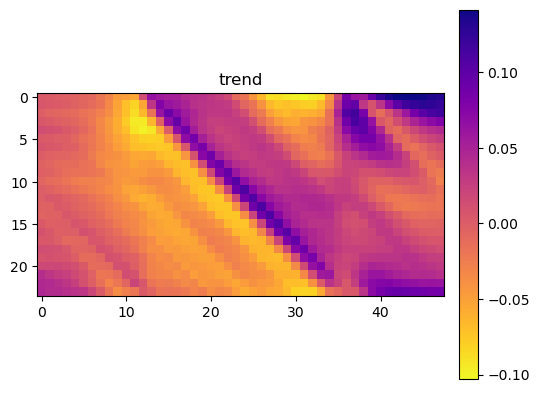

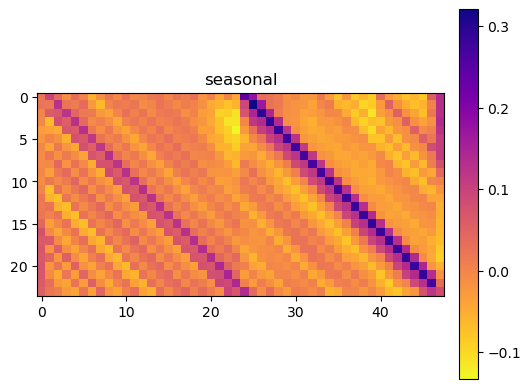

In [243]:
weights_list = {}
weights_list['trend'] = DLinear_model.Linear_Trend.weight.detach().numpy()
weights_list['seasonal'] = DLinear_model.Linear_Seasonal.weight.detach().numpy()

for name, w in weights_list.items():    
    fig, ax = plt.subplots()    
    plt.title(name)
    im = ax.imshow(w, cmap='plasma_r',)
    fig.colorbar(im, pad=0.03)
    plt.show()